# U-Net with Class Weights and Augmentations for Mars Terrain Segmentation

## Overview
- U-Net model for semantic segmentation of Mars terrain images
- Trained with class weights and data augmentations

## Architecture
- **Model**: U-Net
- **Layers**:
  - Contraction: Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D
  - Bottleneck: Conv2D, BatchNormalization, ReLU, Dropout
  - Expansive: Conv2DTranspose, concatenate, BatchNormalization, ReLU
  - Output: Conv2D with softmax activation

## Parameters
- **Batch Size**: 32
- **Learning Rate**: 1e-3
- **Early Stopping Patience**: 50
- **Maximum Epochs**: 500
- **Number of Classes**: 5

## Data Preprocessing
- **Normalization**: Rescale pixel values (0-1)
- **Data Cleaning**: Remove polluted images

## Data Augmentation
- **Random Flip**: Horizontal, vertical
- **Random Brightness**: Max delta 0.05
- **Random Contrast**: Range 0.8 to 1.2
- **GridMask**: Apply GridMask

## Class Weights
- **Calculation**: Using `compute_class_weight`
- **Adjustment**: Scale relative to median, cap at 10
- **Omission**: Background class weight set to 0

## Callbacks
- **Early Stopping**: Monitor `val_mean_iou`, patience 50
- **ReduceLROnPlateau**: Factor 0.35, patience 20
- **Visualization**: Every 5 epochs

## Loss Function
- **Loss**: Sparse Categorical Focal Loss, gamma=1, class weights

## Evaluation
- **Metrics**: Accuracy, MeanIoU (excluding background)

In [1]:
# To clean the img folder
# %rm img/*

## Check production env

In [2]:
import os
# Check if we are in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# check if we are in Kaggle

IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [4]:
# Install albumentations
!pip install -q -U albumentations

In [5]:
SAVE_IMAGES = False

seed = 42

import re, time
from datetime import datetime
import random

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import tqdm as notebook_tqdm

import keras_cv

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [6]:
# Global counter for plot numbering
plot_counter = 0

# Create img directory if it doesn't exist
if SAVE_IMAGES:
    if not os.path.exists('img'):
        os.makedirs('img')

# Original show function
original_show = plt.show

def save_and_show():
    def custom_show(*args, **kwargs):
        global plot_counter
        plot_counter += 1

        # Get current figure and its title
        current_fig = plt.gcf()
        title = current_fig._suptitle
        if title:
            # Clean title for filename
            title_text = re.sub(r'[^\w\s-]', '', title.get_text()).strip()
            title_text = re.sub(r'[-\s]+', '_', title_text)
            filename = f'img/{plot_counter:03d}_{title_text}.pdf'
        else:
            filename = f'img/{plot_counter:03d}.pdf'

        # Save figure
        current_fig.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Saved plot to {filename}")

        # Call original show function
        return original_show(*args, **kwargs)

    # Replace plt.show with custom function
    plt.show = custom_show

if SAVE_IMAGES:
    # Initialize the callback
    save_and_show()

## ⏳ Load the Data

In [7]:
if IN_KAGGLE:
    data = np.load('/kaggle/input/mars-homework-2/mars_for_students.npz')
else:
    data = np.load("../mars_for_students.npz") #remember to change the path accordingly to your folder

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [8]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

# Set the number of classes
NUM_CLASSES = 5

# 🏋🏻‍♂️ Data preprocessing

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


# 👽 Data cleaning

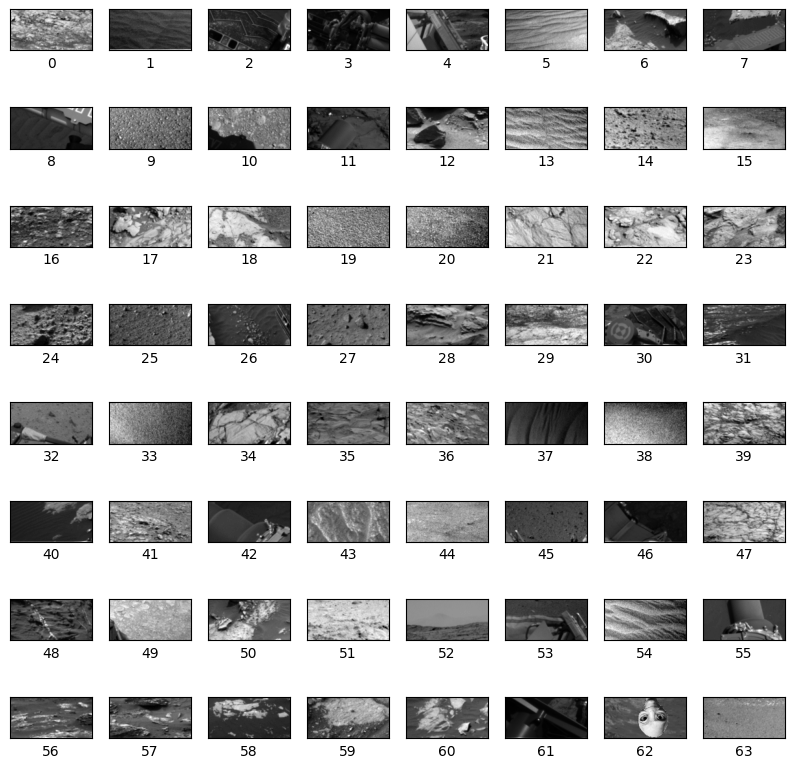

In [10]:
#pot the first 64 images (8x8) in a grid and attach the index of the image as title
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.xlabel(i)
plt.show()

In [11]:
polluted_mask_idx = 62
polluted_mask = y_train[polluted_mask_idx]

print(f"Polluted mask index: {polluted_mask.shape}")

polluted_mask_indices = []
for i, mask in enumerate(y_train):
    if np.array_equal(mask, polluted_mask):
        polluted_mask_indices.append(i)

print(f"Polluted mask indices: {polluted_mask_indices}")
print(f"Number of polluted masks: {len(polluted_mask_indices)}")

Polluted mask index: (64, 128)
Polluted mask indices: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Number of polluted masks: 110


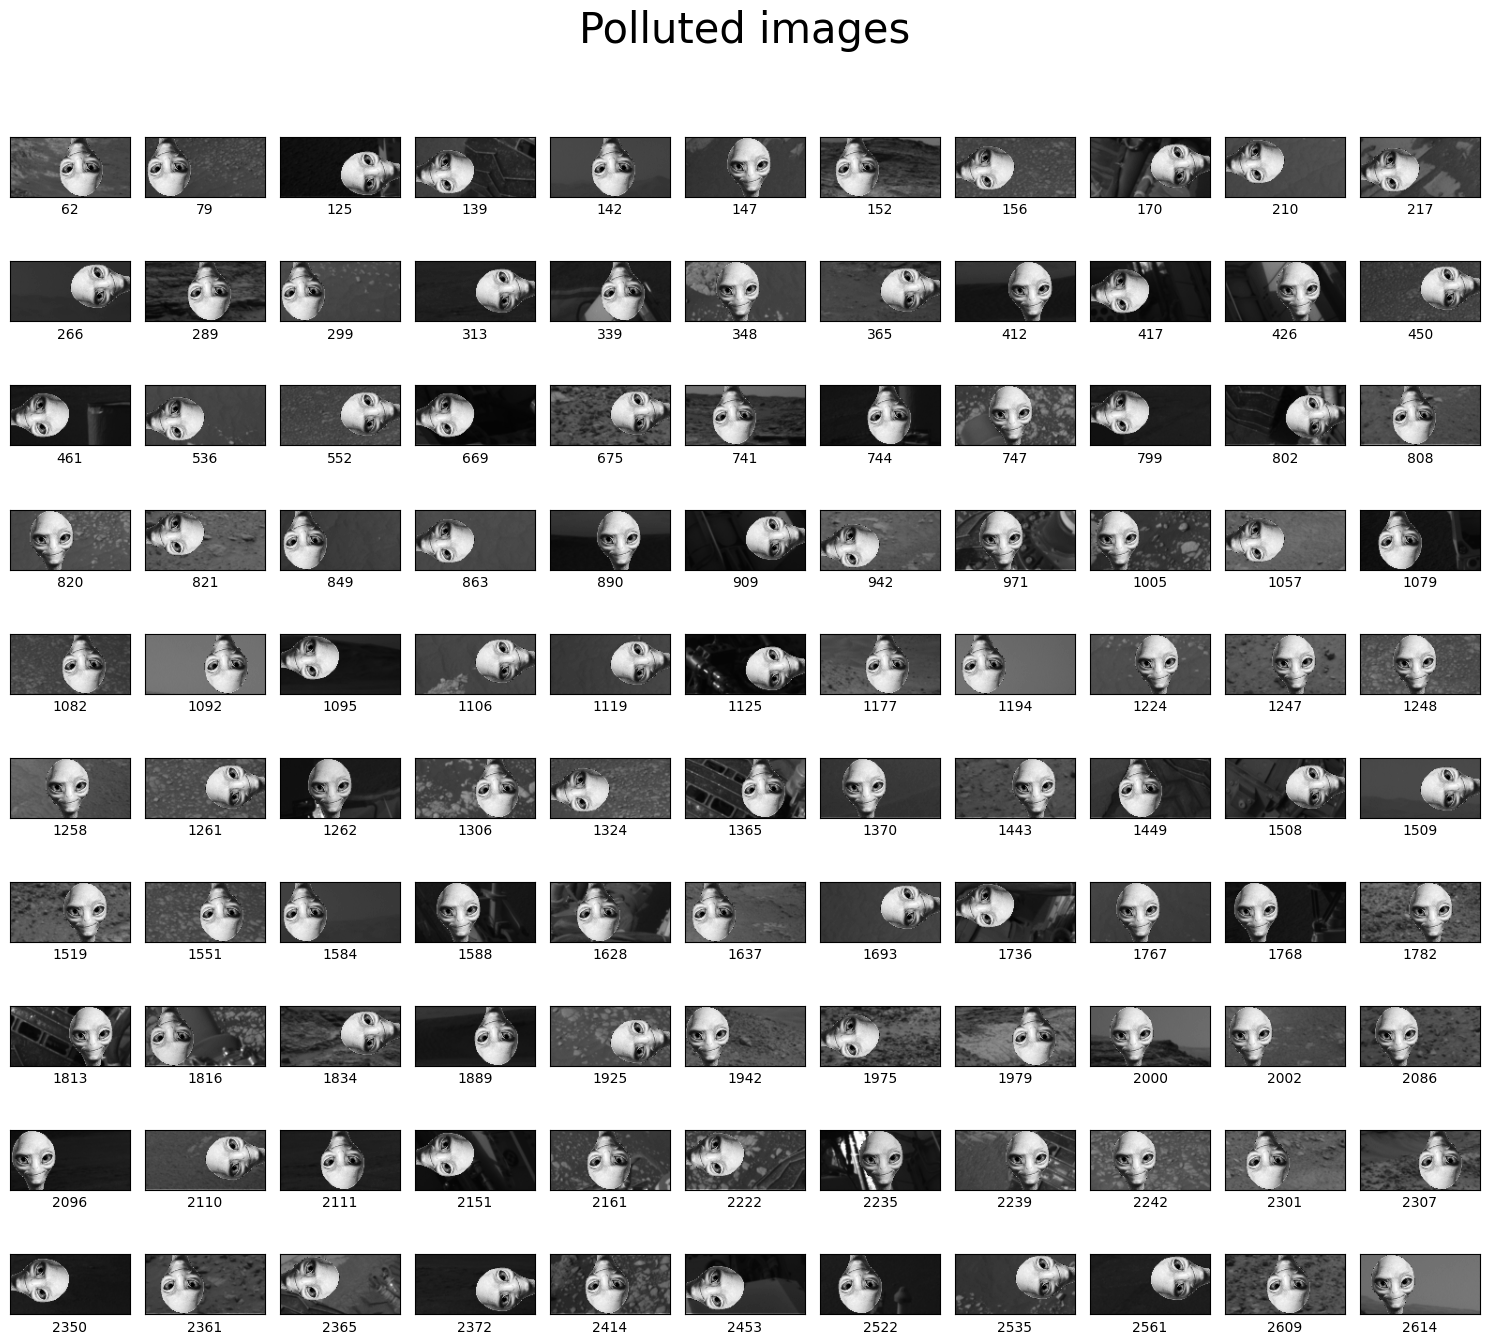

In [12]:
plt.figure(figsize=(15, 15))
num_images = len(polluted_mask_indices)
grid_size = int(np.ceil(np.sqrt(num_images)))

for i, idx in enumerate(polluted_mask_indices):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx, :, :, 0], cmap='gray')
    plt.xlabel(idx)

plt.suptitle("Polluted images", fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [13]:
# Now remove from the x_train of polluted images using the polluted_mask_indices
X_train_clean = np.delete(X_train, polluted_mask_indices, axis=0)
y_train_clean = np.delete(y_train, polluted_mask_indices, axis=0)

print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"y_train_clean shape: {y_train_clean.shape}")

X_train_clean shape: (2505, 64, 128, 1)
y_train_clean shape: (2505, 64, 128)


# Data distribution

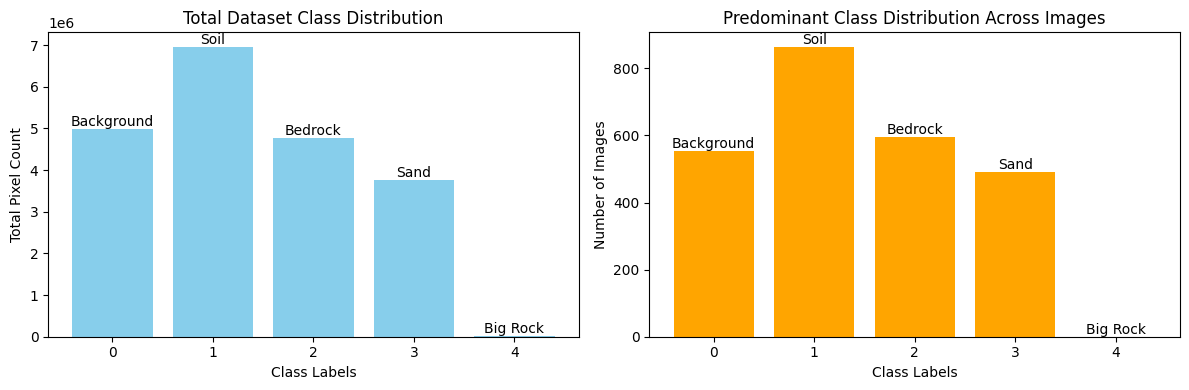

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_label_distribution(y_train_clean):
    NUM_CLASSES = 5  # Number of classes
    class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
    
    total_class_counts = Counter()
    predominant_classes = []

    # Calculate class distribution and predominant class for each image
    for mask in y_train_clean:
        class_counts = Counter(mask.flatten())
        predominant_class = max(class_counts, key=class_counts.get)
        predominant_classes.append(predominant_class)

        # Update total counts
        for label, count in class_counts.items():
            total_class_counts[label] += count

    # Plot overall class distribution
    labels, counts = zip(*sorted(total_class_counts.items()))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Total Pixel Count')
    plt.title('Total Dataset Class Distribution')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    # Analyze predominant classes
    predominant_class_counts = Counter(predominant_classes)
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(NUM_CLASSES), [predominant_class_counts.get(i, 0) for i in range(NUM_CLASSES)], color='orange')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title('Predominant Class Distribution Across Images')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Return summary statistics
    return {
        'total_class_distribution': total_class_counts,
        'predominant_class_distribution': predominant_class_counts
    }
#Call the plot_label_distribution function to plot the label distribution of the training set and get the predominant classes for each image in the training set
predominant_classes = analyze_label_distribution(y_train_clean)

## Class Weights

In [15]:
from sklearn.utils.class_weight import compute_class_weight
#STANDARD WEIGHT CALCULATION
def calculate_class_weights(y_train_clean, num_classes):
    # Flatten all masks into a single array to calculate pixel-level class frequencies
    all_pixels = np.concatenate([mask.flatten() for mask in y_train_clean])

    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=all_pixels
    )

    # Convert to dictionary format for easier usage
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    return class_weight_dict
#Call the calculate_class_weights function to calculate the class weights for the training set
class_weights = calculate_class_weights(y_train_clean, NUM_CLASSES)     
print(f"Class weights: {class_weights}")

#ADJUSTED WEIGHT CALCULATION
def adjust_weights_with_median(class_weights):
    # Get the median of the class weights
    median_weight = np.median(list(class_weights.values()))

    # Scale all weights relative to the median
    adjusted_weights = {cls: weight / median_weight for cls, weight in class_weights.items()}
    return adjusted_weights
adjusted_weights = adjust_weights_with_median(class_weights)
print("Adjusted Class Weights:", adjusted_weights)

#CAP WEIGHTS CALCULATION
def cap_weights(class_weights, cap_value):
    capped_weights = {cls: min(weight, cap_value) for cls, weight in class_weights.items()}
    return capped_weights
capped_weights = cap_weights(adjusted_weights, cap_value=10)
print("Capped Class Weights:", capped_weights)

Class weights: {0: 0.8226769183771894, 1: 0.5898914242365618, 2: 0.8591909663562084, 3: 1.088407490884616, 4: 152.21570300040796}
Adjusted Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 177.16166598672254}
Capped Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 10}


# ⛏️ Datasets creation

In [16]:
from sklearn.model_selection import train_test_split

# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train_clean, y_train_clean, test_size=SPLITS_SIZE, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


In [17]:
# Image augmentation

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


@tf.function
def random_brightness(image, label, seed=None):
    """Random brightness with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Reduced max_delta to avoid overly dark images
    image = tf.image.random_brightness(image, max_delta=0.05, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_contrast(image, label, seed=None):
    """Random contrast with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Adjusted range for contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_flip_up_down(image, label, seed=None):
    """Random flip up-down."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

@tf.function
def gridmask(image, label, seed=None):
    """GridMask data augmentation."""
    flip_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(
        flip_prob > 0.5,
        lambda: keras_cv.layers.RandomCutout(width_factor = 0.5, height_factor = 0.3, fill_value = 0.0)(image),
        lambda: image
    )
    # image = tf.cond(
    #     flip_prob > 0.4,
    #     lambda: keras_cv.layers.AugMix(value_range=(0, 255), severity=0.3)(image),
    #     lambda: image
    # )
    image = tf.cond(
        flip_prob > 0.3,
        lambda: keras_cv.layers.GridMask()(image),
        lambda: image
    )

    # Ensure masks only undergo spatial transformations
    label = tf.image.resize_with_crop_or_pad(label, image.shape[0], image.shape[1])
    # Ensure label remains integer
    # label = tf.cast(label, tf.int32)
    
    return image, label


@tf.function
def clip_values(image, label):
    """Clip pixel values between 0 and 1."""
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label



In [18]:
@tf.function
def augment_image(image, label, seed=None):
    """Apply augmentation to image."""

    # Ensure inputs have channel dimension
    if len(tf.shape(image)) < 3:
        image = tf.expand_dims(image, axis=-1)
    if len(tf.shape(label)) < 3:
        label = tf.expand_dims(label, axis=-1)
        
    image = tf.cast(image, tf.float32)
    image, label = random_flip(image, label, seed)
    image, label = random_brightness(image, label, seed)
    image, label = random_contrast(image, label, seed)
    image, label = random_flip_up_down(image, label, seed)
    image, label = clip_values(image,label)
    image, label = gridmask(image, label, seed)
    
    return image, label

In [19]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: augment_image(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [20]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


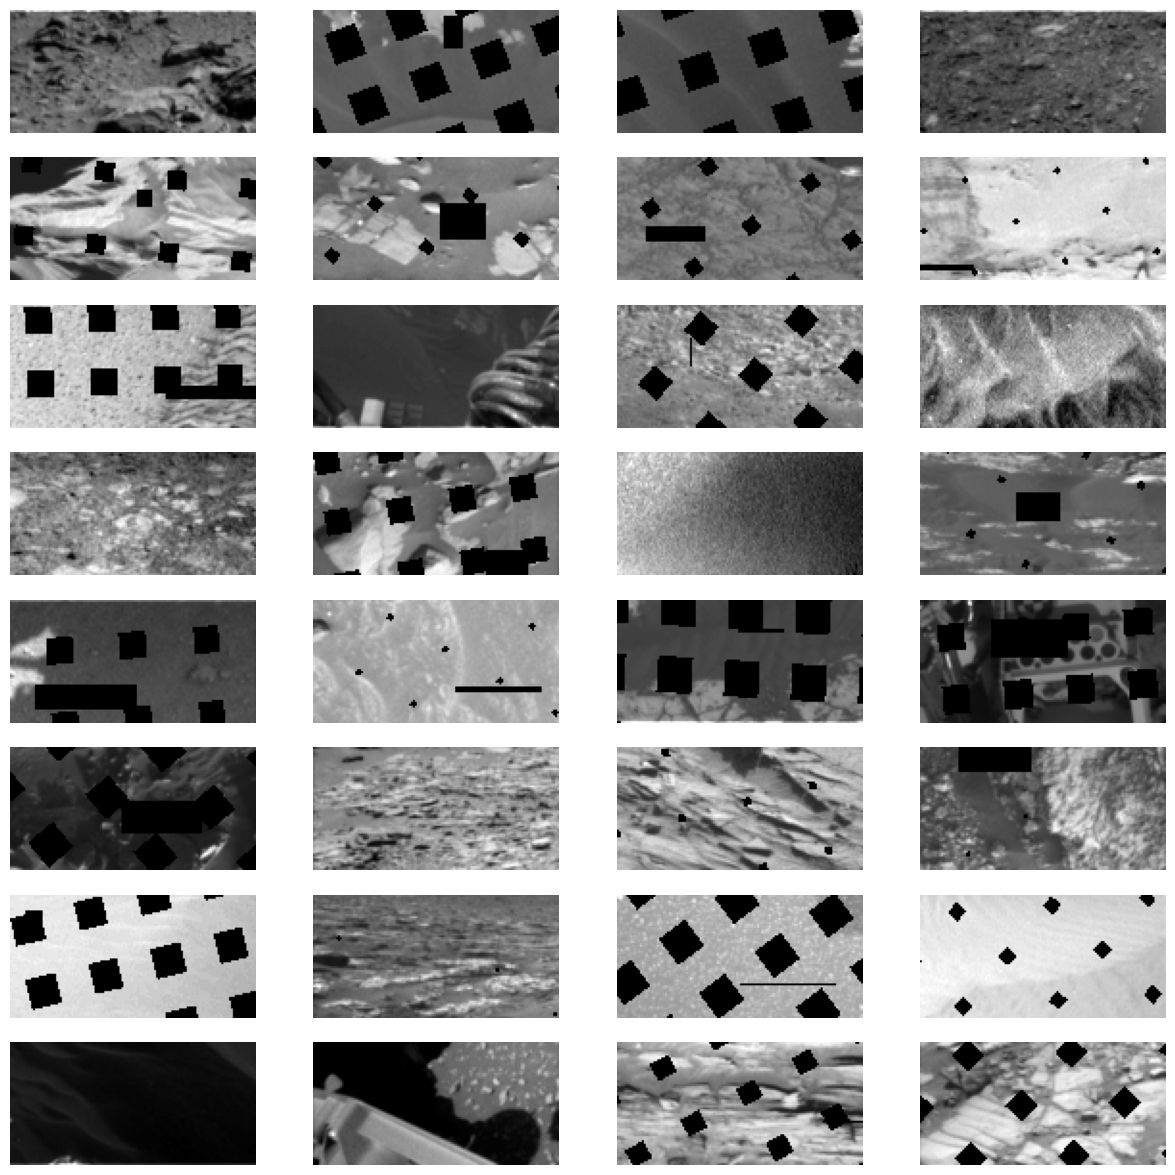

In [21]:
# Plot a batch of 32 images taken from the training dataset
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis("off")
plt.show()

In [22]:
def load_single_image(image_array, label_array, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape from numpy arrays.
    """
    # Ensure the image has 1 channel
    if image_array.ndim == 2:
        image_array = np.expand_dims(image_array, axis=-1)

    # Resize the image to the fixed size
    image = tf.image.resize(image_array, input_size)
    image = tf.cast(image, tf.float32)

    # Ensure the label has a single channel
    if label_array.ndim == 2:
        label_array = np.expand_dims(label_array, axis=-1)

    # Resize the label to the fixed size
    label = tf.image.resize(label_array, input_size, method='bilinear')
    label = tf.cast(label, tf.int32)

    return image, label

In [23]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

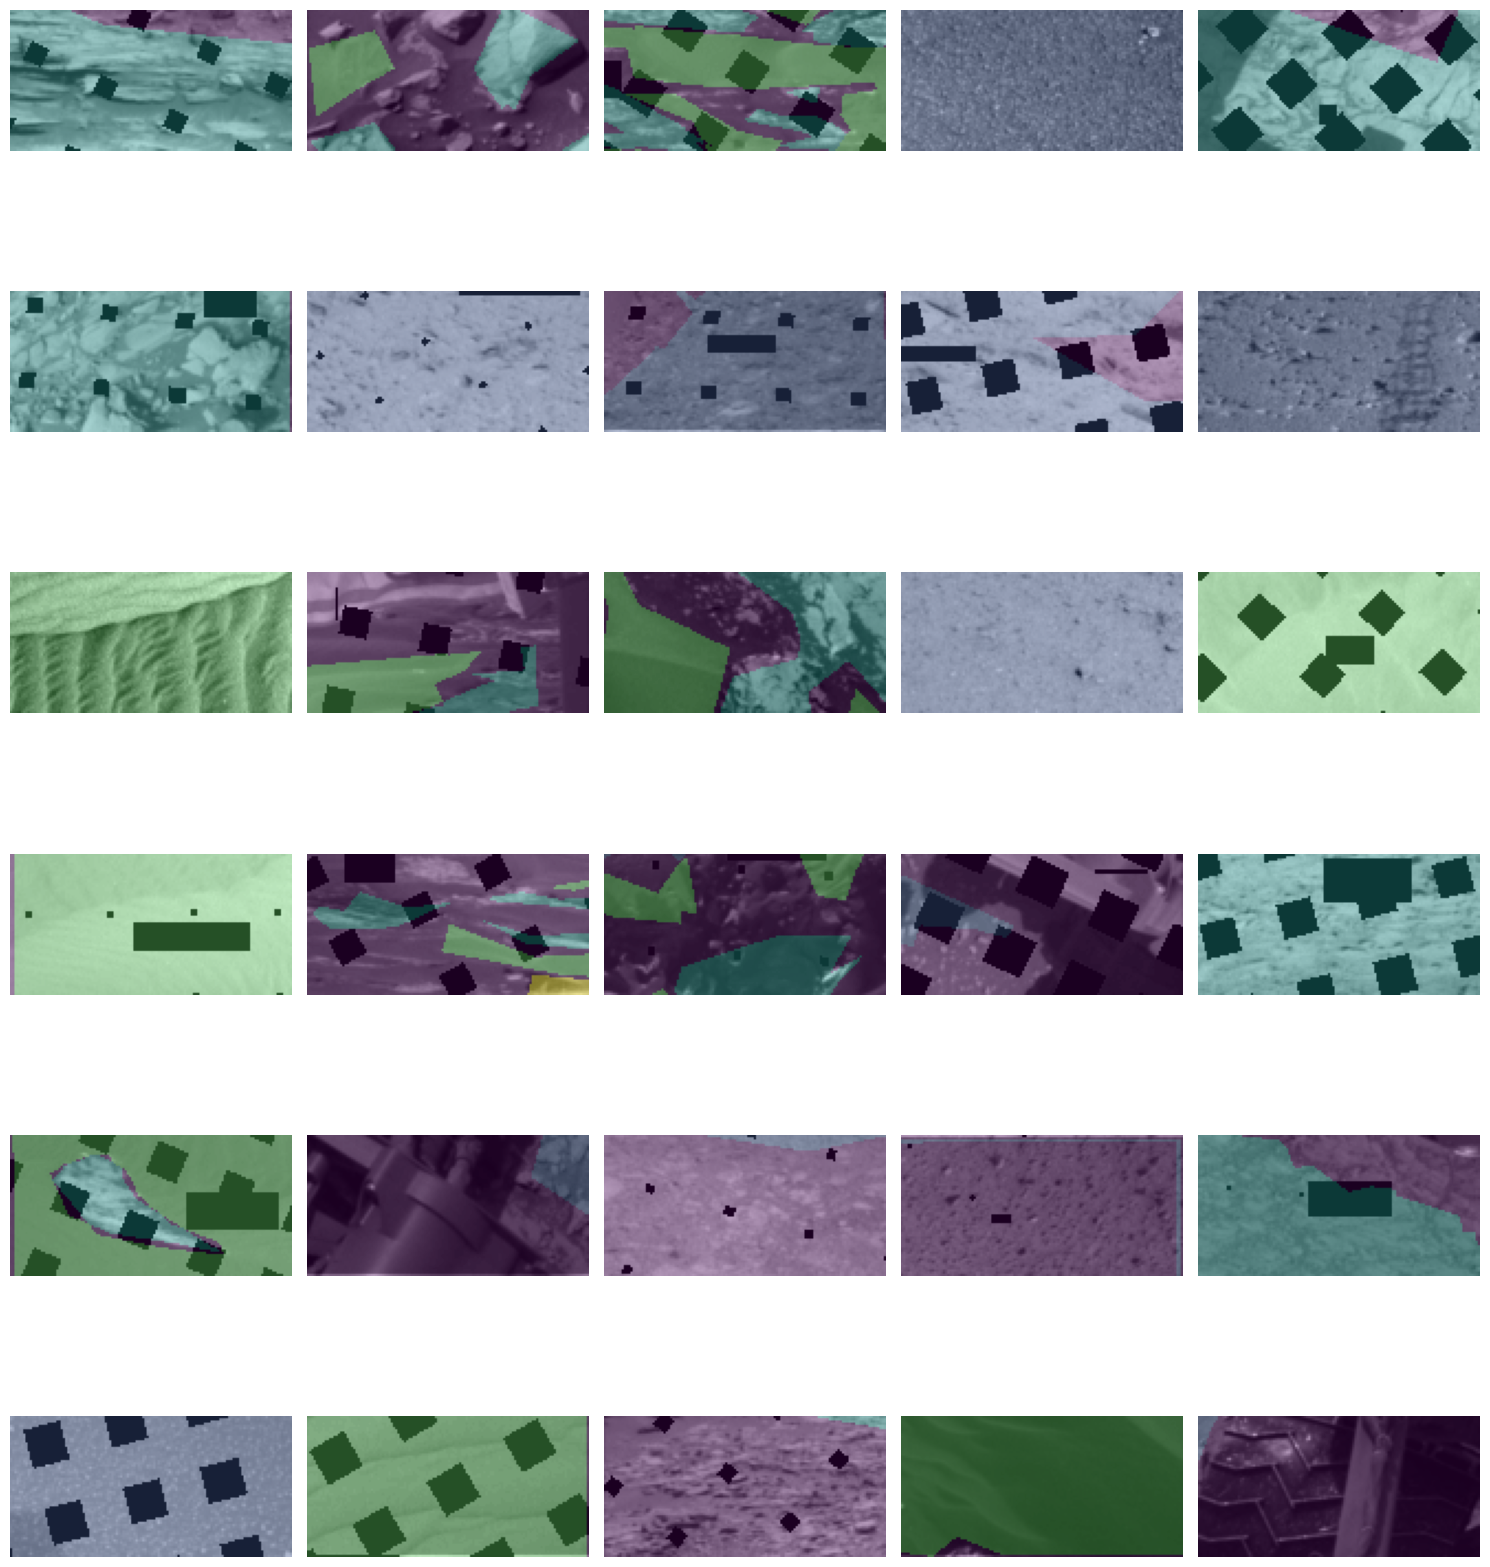

In [24]:
def plot_batch_with_labels(dataset, num_samples=30, columns=5):
    rows = num_samples // columns
    plt.figure(figsize=(15, 3 * rows))
    
    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for i in range(num_samples):
            plt.subplot(rows, columns, i + 1)
            plt.imshow(images[i], cmap='gray')
            colored_label = apply_colormap(labels_np[i], colormap)
            plt.imshow(colored_label, alpha=0.4)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the batch with labels
plot_batch_with_labels(train_dataset)


## 🛠️ Train and Save the Model

In [25]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [26]:
!pip install focal-loss

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
# Convert class weights dictionary to a tensor
def convert_class_weights_to_tensor(class_weight_dict, num_classes):
    class_weights_list = [class_weight_dict[i] for i in range(num_classes)]
    return tf.constant(class_weights_list, dtype=tf.float32)
capped_weights_tensor = convert_class_weights_to_tensor(capped_weights, NUM_CLASSES)
class_weights_tensor = convert_class_weights_to_tensor(class_weights, NUM_CLASSES)

In [28]:
def omit_background_class_weights(class_weights_tensor, num_classes):
    # Exclude the background class (class 0) by setting its weight to 0
    weights_without_background = class_weights_tensor.numpy().tolist()
    weights_without_background[0] = 0  # Set the background class weight to 0

    # Convert back to a tensor
    return tf.constant(weights_without_background, dtype=tf.float32)

In [29]:
# Use the capped_weights_tensor or class_weights_tensor based on your preference
final_class_weights_tensor = omit_background_class_weights(capped_weights_tensor, NUM_CLASSES)

Model: "U_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 128,   │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 1,399,877 (5.34 MB)

 Trainable params: 1,397,925 (5.33 MB)

 Non-trainable params: 1,952 (7.62 KB)

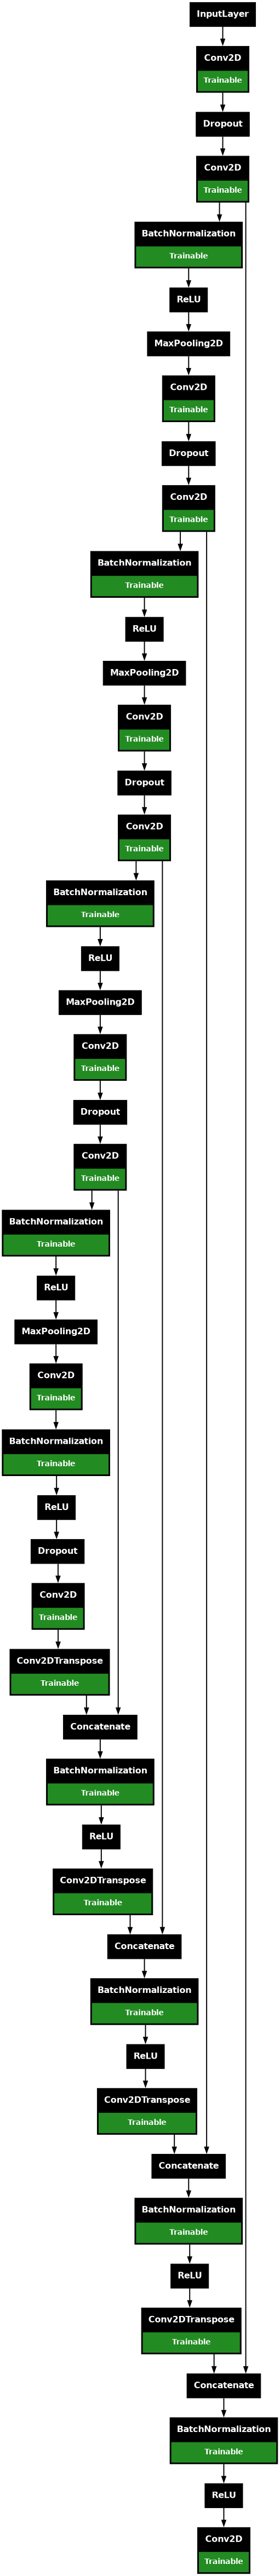

In [30]:
from focal_loss import SparseCategoricalFocalLoss

inputs = tfkl.Input(shape=input_shape)

#Contraction path
c1 = tfkl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tfkl.Dropout(0.1)(c1)
c1 = tfkl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tfkl.BatchNormalization()(c1)
r1 = tfkl.ReLU()(b1)
p1 = tfkl.MaxPooling2D((2, 2))(r1)

c2 = tfkl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tfkl.Dropout(0.1)(c2)
c2 = tfkl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tfkl.BatchNormalization()(c2)
r2 = tfkl.ReLU()(b2)
p2 = tfkl.MaxPooling2D((2, 2))(r2)
 
c3 = tfkl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tfkl.Dropout(0.2)(c3)
c3 = tfkl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tfkl.BatchNormalization()(c3)
r3 = tfkl.ReLU()(b3)
p3 = tfkl.MaxPooling2D((2, 2))(r3)
 
c4 = tfkl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tfkl.Dropout(0.2)(c4)
c4 = tfkl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tfkl.BatchNormalization()(c4)
r4 = tfkl.ReLU()(b4)
p4 = tfkl.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tfkl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tfkl.BatchNormalization()(c5)
r5 = tfkl.ReLU()(b5)
c5 = tfkl.Dropout(0.3)(r5)
c5 = tfkl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tfkl.concatenate([u6, c4])
u6 = tfkl.BatchNormalization()(u6)
u6 = tfkl.ReLU()(u6)

u7 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tfkl.concatenate([u7, c3])
u7 = tfkl.BatchNormalization()(u7)
u7 = tfkl.ReLU()(u7)
 
u8 = tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tfkl.concatenate([u8, c2])
u8 = tfkl.BatchNormalization()(u8)
u8 = tfkl.ReLU()(u8)
 
u9 = tfkl.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tfkl.concatenate([u9, c1], axis=3)
u9 = tfkl.BatchNormalization()(u9)
u9 = tfkl.ReLU()(u9)

outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(u9)

model = tfk.Model(inputs=inputs, outputs=outputs, name="U_net")

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(
    loss=SparseCategoricalFocalLoss(gamma=1, class_weight=final_class_weights_tensor, from_logits=False),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

model.summary()
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [31]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,  
    restore_best_weights=True
)

# Reduce learning rate when the metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',  # Use the correct name for the metric
    factor=0.35,  # Factor by which the learning rate will be reduced
    patience=20,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7  # Lower bound on the learning rate
)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image, self.label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))
            plt.suptitle(f"Epoch {epoch + 1}")

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

vizcallback = VizCallback(image=val_img[0], label=val_lbl[0], frequency=5)

Epoch 1/500


I0000 00:00:1733238435.883045      73 service.cc:145] XLA service 0x7c27ec002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733238435.883199      73 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 6/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2241 - loss: 1.1437 - mean_iou: 0.0809

I0000 00:00:1733238452.173087      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2418 - loss: 0.9527 - mean_iou: 0.1025

I0000 00:00:1733238467.425088      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_3', 16 bytes spill stores, 16 bytes spill loads

W0000 00:00:1733238470.679190      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_focal_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733238472.764732      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_focal_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


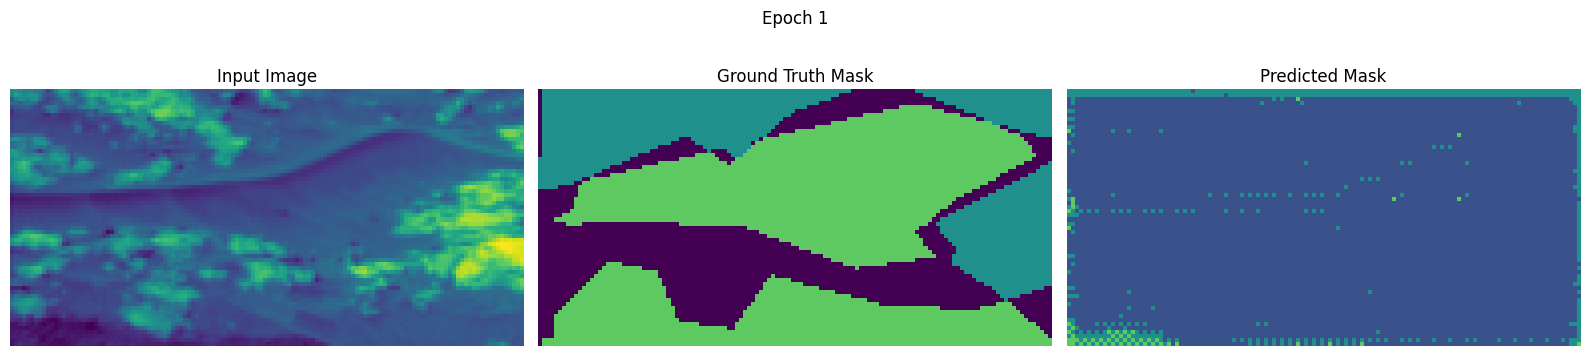

60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 398ms/step - accuracy: 0.2420 - loss: 0.9508 - mean_iou: 0.1028 - val_accuracy: 0.3014 - val_loss: 0.7159 - val_mean_iou: 0.1146
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2945 - loss: 0.6852 - mean_iou: 0.1419 - val_accuracy: 0.3106 - val_loss: 0.6293 - val_mean_iou: 0.1888
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3213 - loss: 0.6097 - mean_iou: 0.1631 - val_accuracy: 0.2802 - val_loss: 0.5979 - val_mean_iou: 0.1659
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3618 - loss: 0.5288 - mean_iou: 0.1953 - val_accuracy: 0.3507 - val_loss: 0.6094 - val_mean_iou: 0.1991
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4177 - loss: 0.4494 - mean_iou: 0.2965 - val_accuracy: 0.3861 - val_loss: 0.6539 - val_mean_iou: 0.2084
Epoch 6/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4249 - loss: 0.4355 - mean_iou: 0.2507

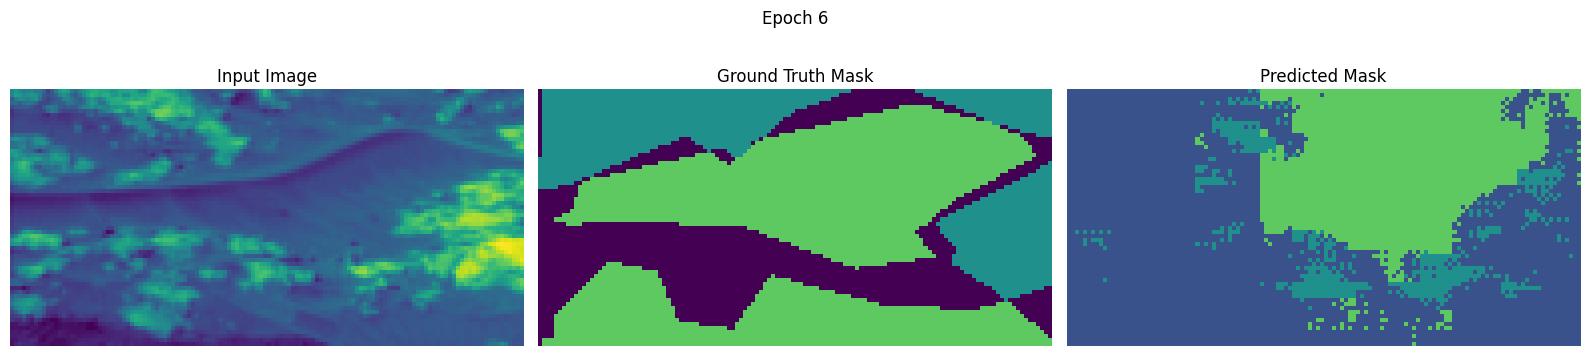

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4253 - loss: 0.4349 - mean_iou: 0.2507 - val_accuracy: 0.4083 - val_loss: 0.5000 - val_mean_iou: 0.2524
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4441 - loss: 0.4292 - mean_iou: 0.3180 - val_accuracy: 0.3896 - val_loss: 0.4711 - val_mean_iou: 0.2494
Epoch 8/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4867 - loss: 0.3919 - mean_iou: 0.3607 - val_accuracy: 0.3653 - val_loss: 0.5459 - val_mean_iou: 0.2164
Epoch 9/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5241 - loss: 0.3562 - mean_iou: 0.3985 - val_accuracy: 0.3926 - val_loss: 0.5364 - val_mean_iou: 0.2412
Epoch 10/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5421 - loss: 0.3426 - mean_iou: 0.4208 - val_accuracy: 0.4386 - val_loss: 0.4437 - val_mean_iou: 0.2911
Epoch 11/500
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5388 - loss: 0.3499 - mean_iou: 0.4130

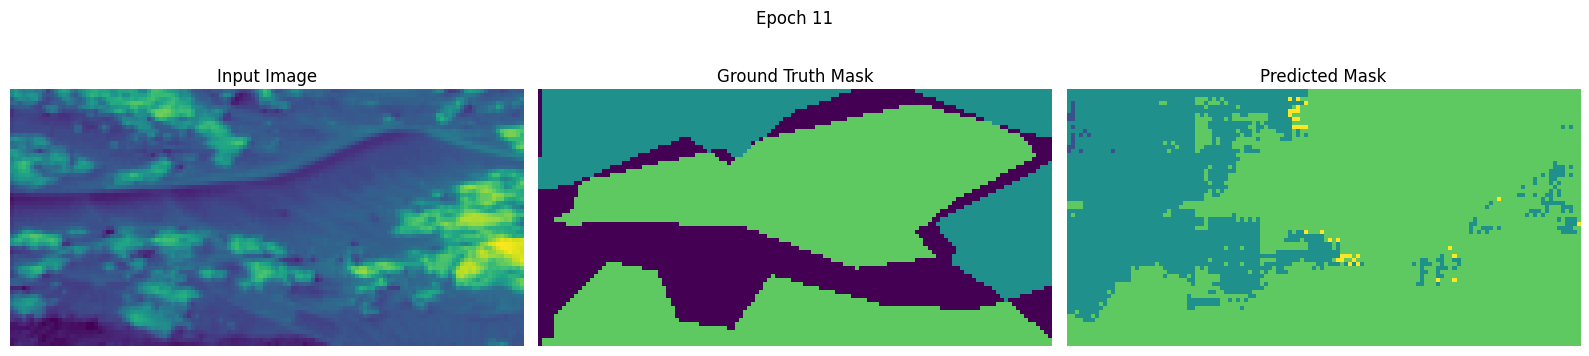

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5388 - loss: 0.3497 - mean_iou: 0.4132 - val_accuracy: 0.3832 - val_loss: 0.8788 - val_mean_iou: 0.2598
Epoch 12/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5286 - loss: 0.3521 - mean_iou: 0.4040 - val_accuracy: 0.4964 - val_loss: 0.3816 - val_mean_iou: 0.3713
Epoch 13/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5500 - loss: 0.3215 - mean_iou: 0.4318 - val_accuracy: 0.4170 - val_loss: 0.4856 - val_mean_iou: 0.2882
Epoch 14/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5698 - loss: 0.3116 - mean_iou: 0.4534 - val_accuracy: 0.4574 - val_loss: 0.4162 - val_mean_iou: 0.3336
Epoch 15/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5746 - loss: 0.3013 - mean_iou: 0.4605 - val_accuracy: 0.4399 - val_loss: 0.4431 - val_mean_iou: 0.3224
Epoch 16/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5842 - loss: 0.2859 - mean_iou: 0.4822

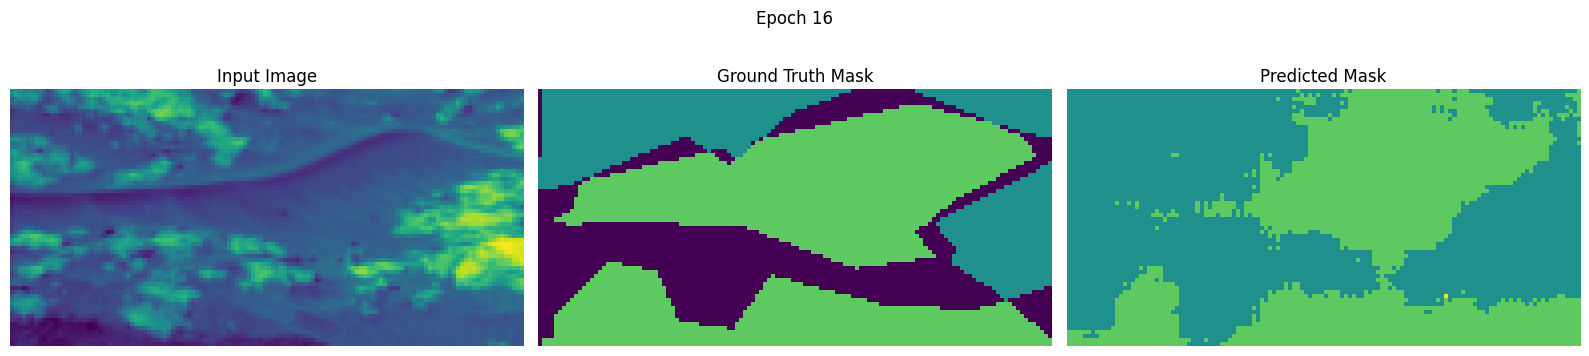

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5843 - loss: 0.2854 - mean_iou: 0.4826 - val_accuracy: 0.5460 - val_loss: 0.3353 - val_mean_iou: 0.4330
Epoch 17/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5729 - loss: 0.2985 - mean_iou: 0.4660 - val_accuracy: 0.5170 - val_loss: 0.3211 - val_mean_iou: 0.3956
Epoch 18/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5754 - loss: 0.2884 - mean_iou: 0.4657 - val_accuracy: 0.5633 - val_loss: 0.2904 - val_mean_iou: 0.4699
Epoch 19/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5903 - loss: 0.2761 - mean_iou: 0.4901 - val_accuracy: 0.5408 - val_loss: 0.3540 - val_mean_iou: 0.4535
Epoch 20/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5954 - loss: 0.2725 - mean_iou: 0.4884 - val_accuracy: 0.5484 - val_loss: 0.3396 - val_mean_iou: 0.4644
Epoch 21/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5973 - loss: 0.2644 - mean_iou: 0.4946

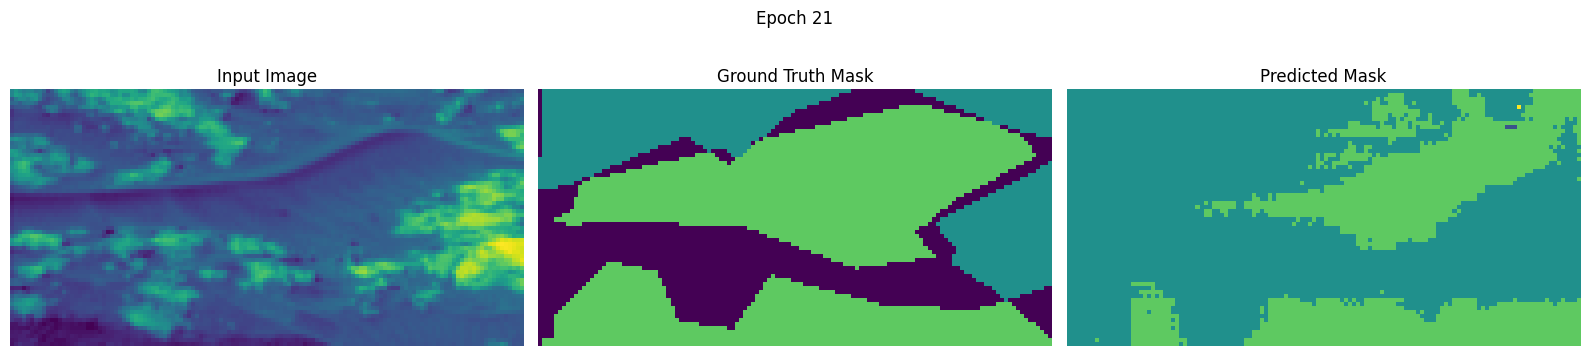

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5973 - loss: 0.2640 - mean_iou: 0.4950 - val_accuracy: 0.5481 - val_loss: 0.2902 - val_mean_iou: 0.4455
Epoch 22/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5876 - loss: 0.2633 - mean_iou: 0.4901 - val_accuracy: 0.4670 - val_loss: 0.4046 - val_mean_iou: 0.3646
Epoch 23/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5932 - loss: 0.2652 - mean_iou: 0.5069 - val_accuracy: 0.6099 - val_loss: 0.2493 - val_mean_iou: 0.5133
Epoch 24/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5915 - loss: 0.2556 - mean_iou: 0.5010 - val_accuracy: 0.6072 - val_loss: 0.2602 - val_mean_iou: 0.5156
Epoch 25/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6082 - loss: 0.2433 - mean_iou: 0.5227 - val_accuracy: 0.5404 - val_loss: 0.3776 - val_mean_iou: 0.4370
Epoch 26/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6120 - loss: 0.2433 - mean_iou: 0.5306

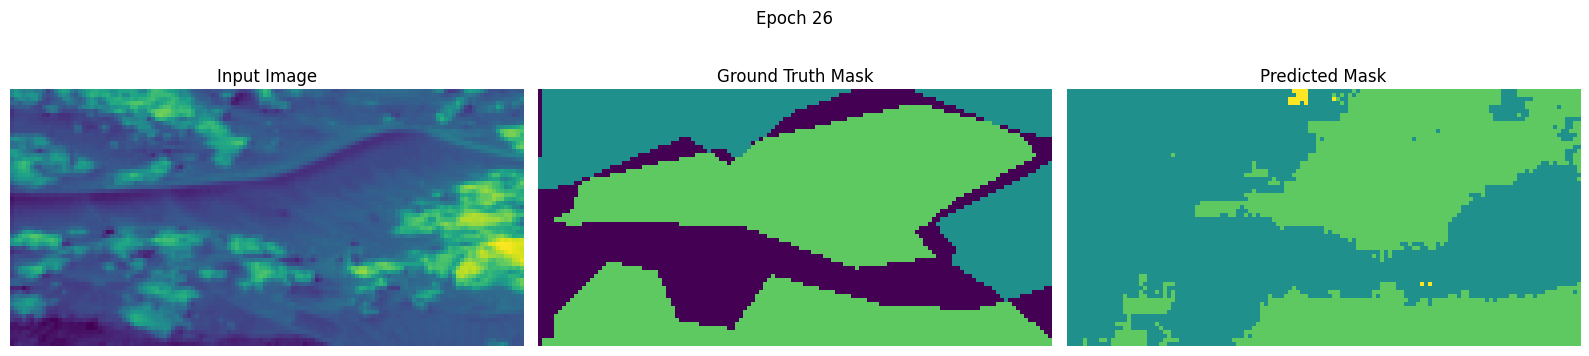

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6121 - loss: 0.2428 - mean_iou: 0.5309 - val_accuracy: 0.6066 - val_loss: 0.2593 - val_mean_iou: 0.5242
Epoch 27/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6149 - loss: 0.2406 - mean_iou: 0.5383 - val_accuracy: 0.5179 - val_loss: 0.3273 - val_mean_iou: 0.4146
Epoch 28/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6193 - loss: 0.2205 - mean_iou: 0.5461 - val_accuracy: 0.6051 - val_loss: 0.2519 - val_mean_iou: 0.5249
Epoch 29/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6232 - loss: 0.2155 - mean_iou: 0.5480 - val_accuracy: 0.4890 - val_loss: 0.3499 - val_mean_iou: 0.3874
Epoch 30/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6271 - loss: 0.2183 - mean_iou: 0.5567 - val_accuracy: 0.5959 - val_loss: 0.2516 - val_mean_iou: 0.5103
Epoch 31/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6208 - loss: 0.2173 - mean_iou: 0.5555

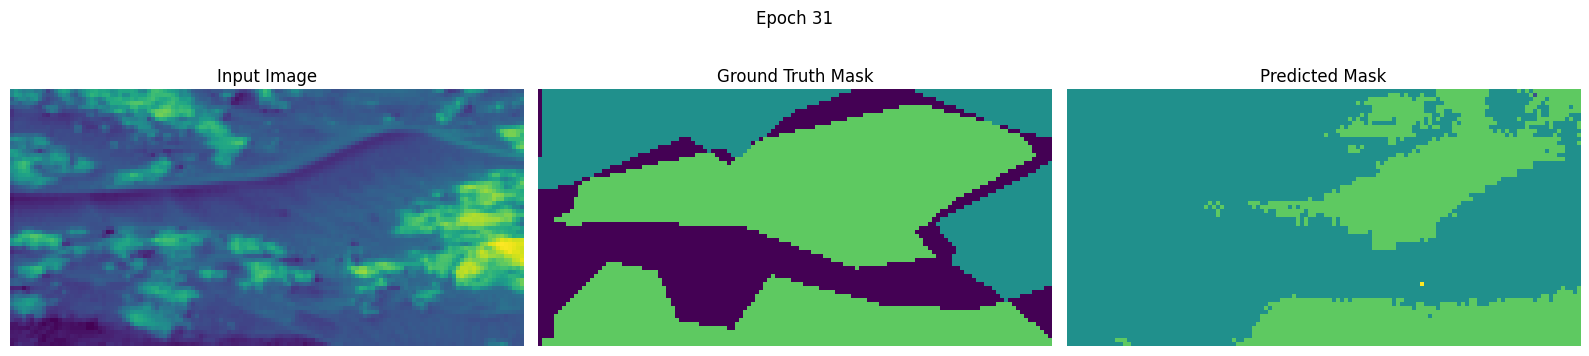

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6210 - loss: 0.2169 - mean_iou: 0.5559 - val_accuracy: 0.6175 - val_loss: 0.2262 - val_mean_iou: 0.5392
Epoch 32/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6323 - loss: 0.2104 - mean_iou: 0.5635 - val_accuracy: 0.6298 - val_loss: 0.2236 - val_mean_iou: 0.5451
Epoch 33/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6334 - loss: 0.2070 - mean_iou: 0.5789 - val_accuracy: 0.4958 - val_loss: 0.3580 - val_mean_iou: 0.3946
Epoch 34/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6244 - loss: 0.2072 - mean_iou: 0.5690 - val_accuracy: 0.6247 - val_loss: 0.2448 - val_mean_iou: 0.5484
Epoch 35/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6353 - loss: 0.1957 - mean_iou: 0.5649 - val_accuracy: 0.6247 - val_loss: 0.2468 - val_mean_iou: 0.5406
Epoch 36/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6323 - loss: 0.1993 - mean_iou: 0.5777

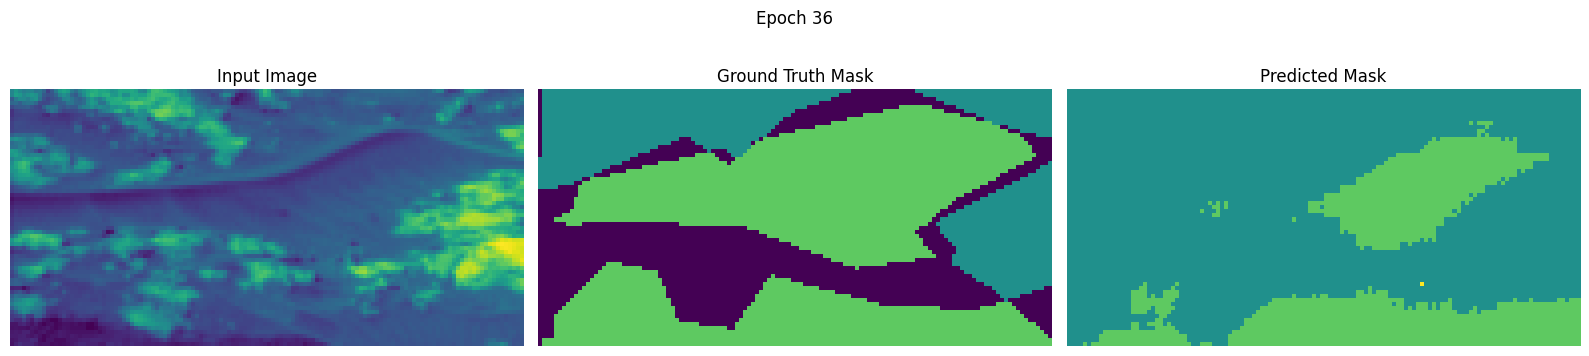

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6326 - loss: 0.1988 - mean_iou: 0.5786 - val_accuracy: 0.5617 - val_loss: 0.2902 - val_mean_iou: 0.4693
Epoch 37/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6362 - loss: 0.1958 - mean_iou: 0.5723 - val_accuracy: 0.6260 - val_loss: 0.2524 - val_mean_iou: 0.5383
Epoch 38/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6395 - loss: 0.1799 - mean_iou: 0.5977 - val_accuracy: 0.6383 - val_loss: 0.2127 - val_mean_iou: 0.5611
Epoch 39/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6486 - loss: 0.1667 - mean_iou: 0.6059 - val_accuracy: 0.6245 - val_loss: 0.2311 - val_mean_iou: 0.5442
Epoch 40/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6509 - loss: 0.1710 - mean_iou: 0.6231 - val_accuracy: 0.6465 - val_loss: 0.2178 - val_mean_iou: 0.5650
Epoch 41/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6454 - loss: 0.1671 - mean_iou: 0.6214

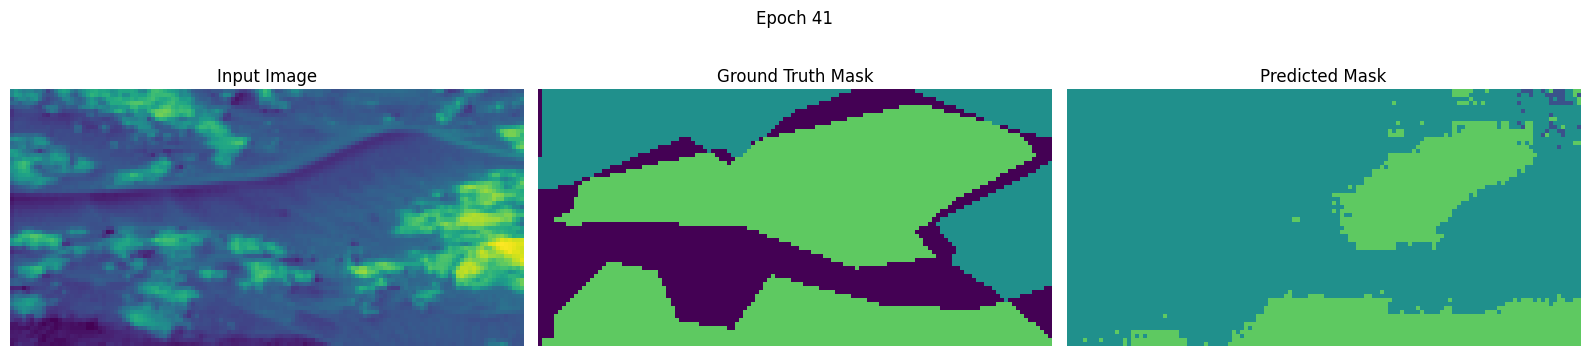

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6456 - loss: 0.1668 - mean_iou: 0.6218 - val_accuracy: 0.5601 - val_loss: 0.2899 - val_mean_iou: 0.4603
Epoch 42/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6429 - loss: 0.1743 - mean_iou: 0.6075 - val_accuracy: 0.6338 - val_loss: 0.2311 - val_mean_iou: 0.5507
Epoch 43/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6577 - loss: 0.1567 - mean_iou: 0.6386 - val_accuracy: 0.6466 - val_loss: 0.2059 - val_mean_iou: 0.5707
Epoch 44/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6605 - loss: 0.1496 - mean_iou: 0.6560 - val_accuracy: 0.6456 - val_loss: 0.2065 - val_mean_iou: 0.5700
Epoch 45/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6596 - loss: 0.1522 - mean_iou: 0.6318 - val_accuracy: 0.6445 - val_loss: 0.2165 - val_mean_iou: 0.5665
Epoch 46/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6587 - loss: 0.1508 - mean_iou: 0.6635

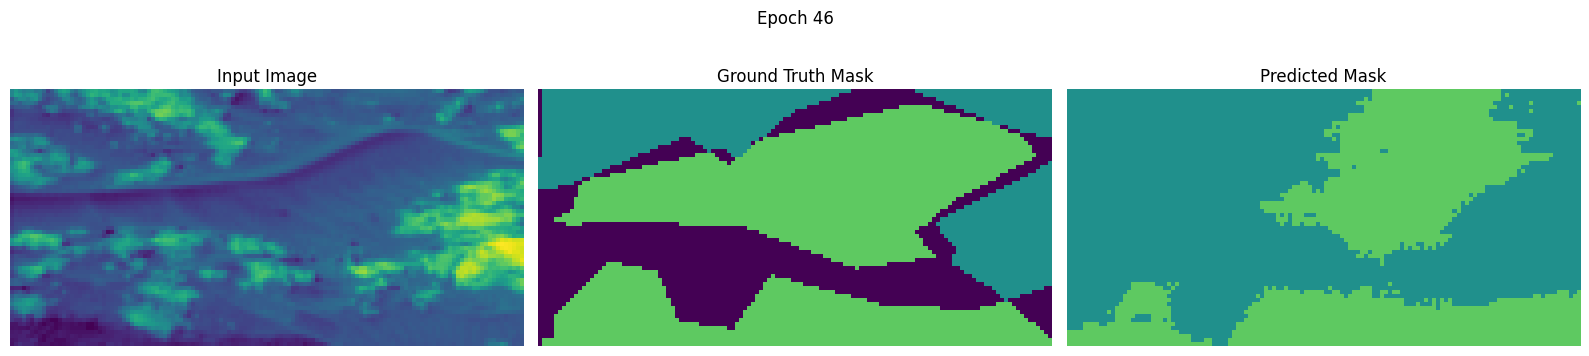

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6589 - loss: 0.1505 - mean_iou: 0.6636 - val_accuracy: 0.6427 - val_loss: 0.2442 - val_mean_iou: 0.5632
Epoch 47/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6590 - loss: 0.1488 - mean_iou: 0.6640 - val_accuracy: 0.5721 - val_loss: 0.2875 - val_mean_iou: 0.4777
Epoch 48/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6623 - loss: 0.1458 - mean_iou: 0.6922 - val_accuracy: 0.6459 - val_loss: 0.2034 - val_mean_iou: 0.5731
Epoch 49/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6598 - loss: 0.1544 - mean_iou: 0.6423 - val_accuracy: 0.6499 - val_loss: 0.1989 - val_mean_iou: 0.5774
Epoch 50/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6634 - loss: 0.1484 - mean_iou: 0.6478 - val_accuracy: 0.6254 - val_loss: 0.2281 - val_mean_iou: 0.5452
Epoch 51/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6688 - loss: 0.1319 - mean_iou: 0.6857

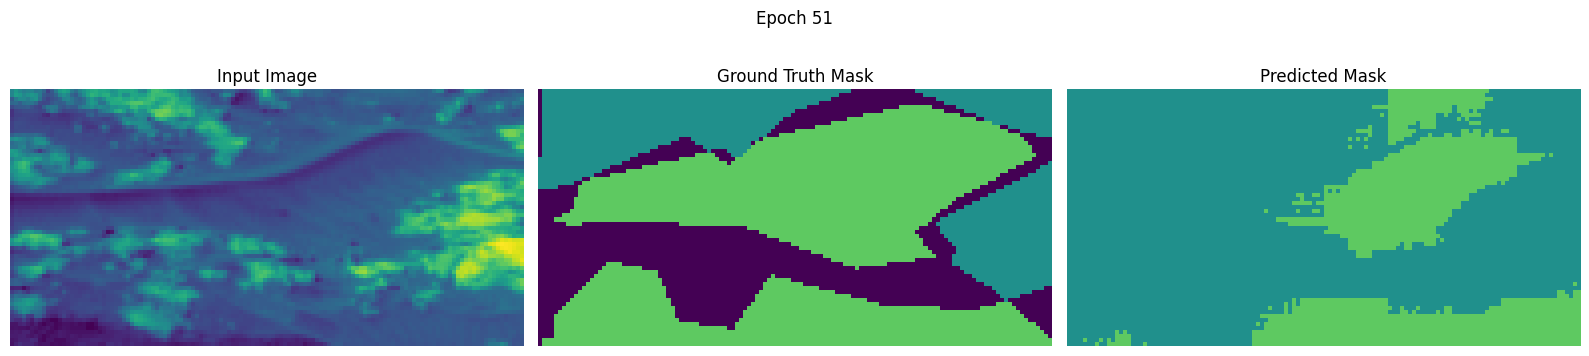

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6688 - loss: 0.1319 - mean_iou: 0.6856 - val_accuracy: 0.6585 - val_loss: 0.1992 - val_mean_iou: 0.5818
Epoch 52/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6666 - loss: 0.1397 - mean_iou: 0.6714 - val_accuracy: 0.6404 - val_loss: 0.2160 - val_mean_iou: 0.5676
Epoch 53/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6684 - loss: 0.1372 - mean_iou: 0.6777 - val_accuracy: 0.6496 - val_loss: 0.2249 - val_mean_iou: 0.5742
Epoch 54/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6686 - loss: 0.1430 - mean_iou: 0.6814 - val_accuracy: 0.6478 - val_loss: 0.2487 - val_mean_iou: 0.5687
Epoch 55/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6715 - loss: 0.1367 - mean_iou: 0.6876 - val_accuracy: 0.6484 - val_loss: 0.1895 - val_mean_iou: 0.5727
Epoch 56/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6682 - loss: 0.1303 - mean_iou: 0.6765

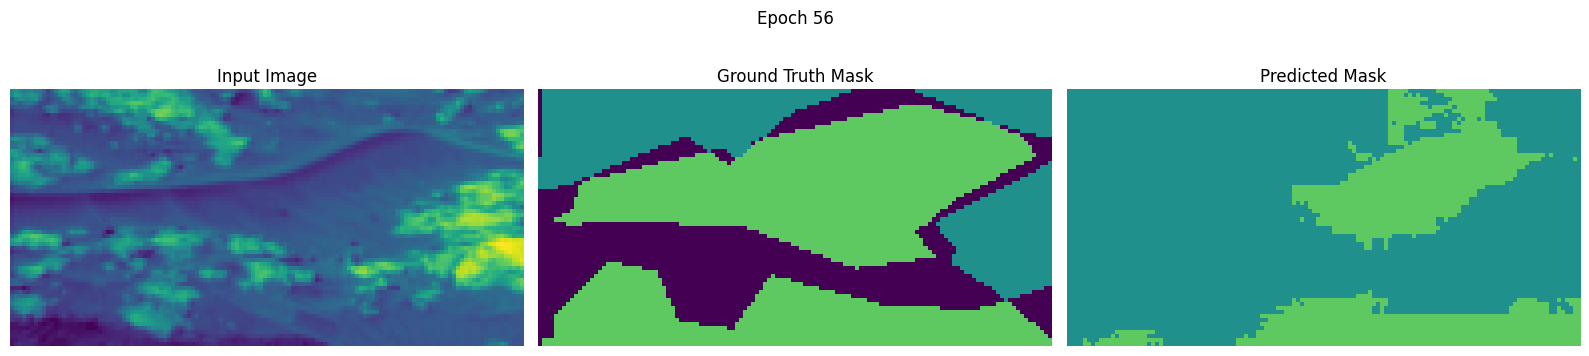

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6682 - loss: 0.1302 - mean_iou: 0.6764 - val_accuracy: 0.6662 - val_loss: 0.2053 - val_mean_iou: 0.5945
Epoch 57/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6712 - loss: 0.1342 - mean_iou: 0.6613 - val_accuracy: 0.6579 - val_loss: 0.1950 - val_mean_iou: 0.5816
Epoch 58/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6735 - loss: 0.1246 - mean_iou: 0.7083 - val_accuracy: 0.6623 - val_loss: 0.2306 - val_mean_iou: 0.5832
Epoch 59/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6704 - loss: 0.1264 - mean_iou: 0.7032 - val_accuracy: 0.6484 - val_loss: 0.2116 - val_mean_iou: 0.5763
Epoch 60/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6753 - loss: 0.1240 - mean_iou: 0.6932 - val_accuracy: 0.5556 - val_loss: 0.3398 - val_mean_iou: 0.4535
Epoch 61/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6799 - loss: 0.1115 - mean_iou: 0.7183

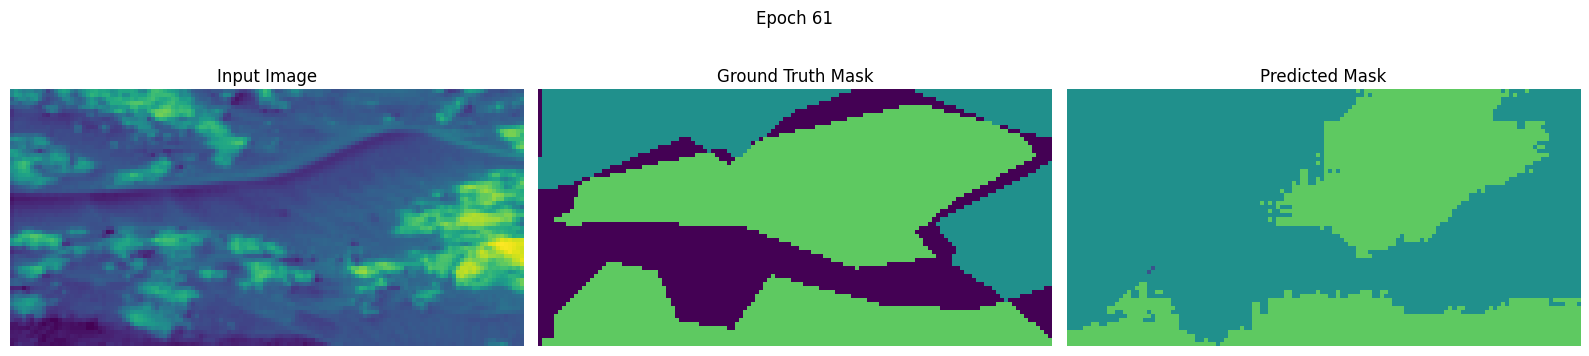

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6798 - loss: 0.1117 - mean_iou: 0.7178 - val_accuracy: 0.6323 - val_loss: 0.2641 - val_mean_iou: 0.5434
Epoch 62/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6820 - loss: 0.1144 - mean_iou: 0.7098 - val_accuracy: 0.6399 - val_loss: 0.2166 - val_mean_iou: 0.5648
Epoch 63/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6724 - loss: 0.1147 - mean_iou: 0.6954 - val_accuracy: 0.6504 - val_loss: 0.2358 - val_mean_iou: 0.5732
Epoch 64/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6714 - loss: 0.1206 - mean_iou: 0.7012 - val_accuracy: 0.6717 - val_loss: 0.1908 - val_mean_iou: 0.6042
Epoch 65/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6873 - loss: 0.1048 - mean_iou: 0.7222 - val_accuracy: 0.6676 - val_loss: 0.1869 - val_mean_iou: 0.6031
Epoch 66/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6812 - loss: 0.1075 - mean_iou: 0.7247

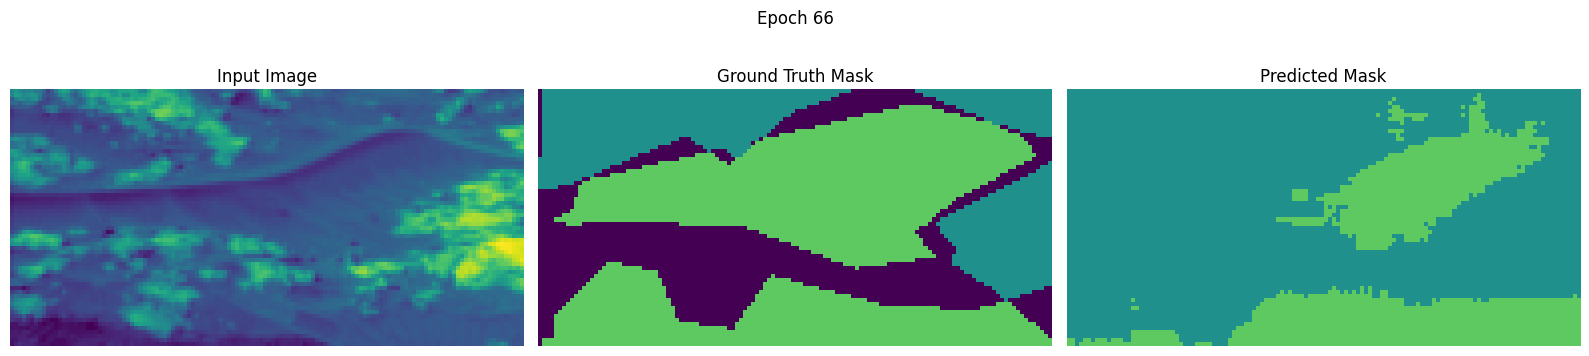

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6812 - loss: 0.1075 - mean_iou: 0.7243 - val_accuracy: 0.6174 - val_loss: 0.2449 - val_mean_iou: 0.5354
Epoch 67/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6760 - loss: 0.1211 - mean_iou: 0.7093 - val_accuracy: 0.5631 - val_loss: 0.3046 - val_mean_iou: 0.4721
Epoch 68/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6935 - loss: 0.0926 - mean_iou: 0.7334 - val_accuracy: 0.6534 - val_loss: 0.2171 - val_mean_iou: 0.5798
Epoch 69/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6855 - loss: 0.1066 - mean_iou: 0.7242 - val_accuracy: 0.6547 - val_loss: 0.2042 - val_mean_iou: 0.5868
Epoch 70/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6861 - loss: 0.1117 - mean_iou: 0.7036 - val_accuracy: 0.6469 - val_loss: 0.2099 - val_mean_iou: 0.5713
Epoch 71/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6855 - loss: 0.1063 - mean_iou: 0.7475

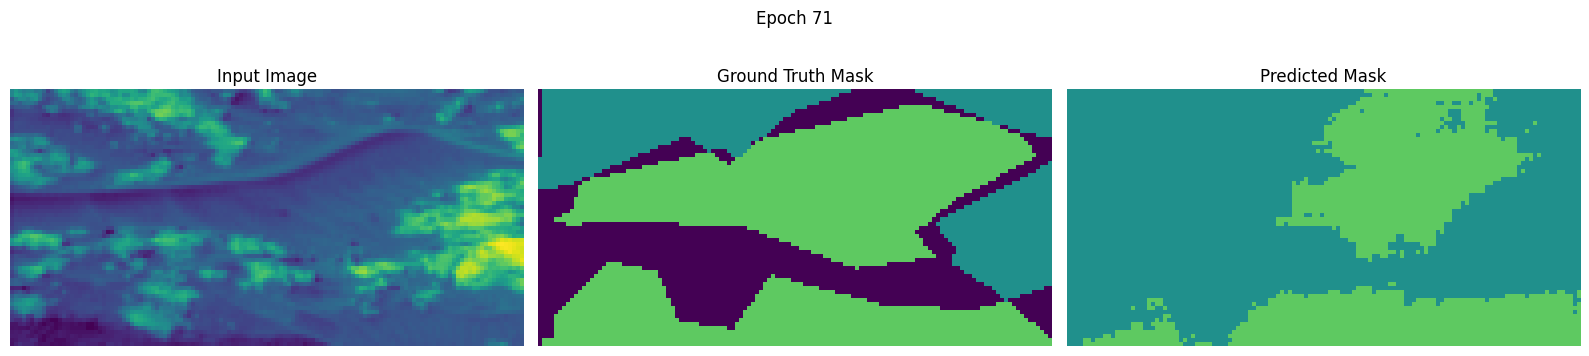

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6854 - loss: 0.1062 - mean_iou: 0.7472 - val_accuracy: 0.6429 - val_loss: 0.2463 - val_mean_iou: 0.5622
Epoch 72/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6819 - loss: 0.1046 - mean_iou: 0.7195 - val_accuracy: 0.6721 - val_loss: 0.2011 - val_mean_iou: 0.6065
Epoch 73/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6911 - loss: 0.1017 - mean_iou: 0.7135 - val_accuracy: 0.5013 - val_loss: 0.4508 - val_mean_iou: 0.3964
Epoch 74/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6953 - loss: 0.1023 - mean_iou: 0.6969 - val_accuracy: 0.6623 - val_loss: 0.2043 - val_mean_iou: 0.5941
Epoch 75/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6831 - loss: 0.1118 - mean_iou: 0.7068 - val_accuracy: 0.6612 - val_loss: 0.1913 - val_mean_iou: 0.5944
Epoch 76/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6883 - loss: 0.0989 - mean_iou: 0.7253

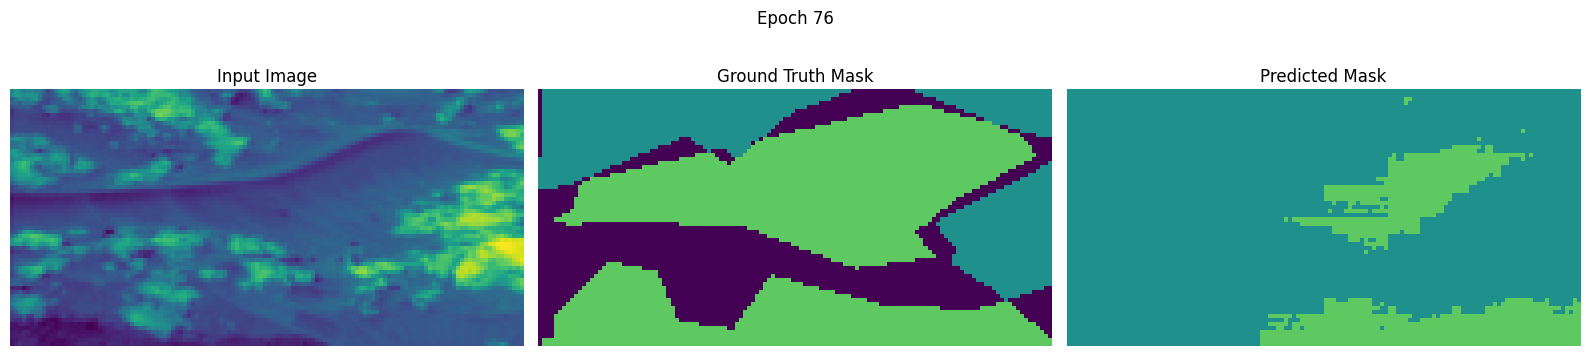

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6883 - loss: 0.0989 - mean_iou: 0.7255 - val_accuracy: 0.6548 - val_loss: 0.2357 - val_mean_iou: 0.5756
Epoch 77/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6988 - loss: 0.0900 - mean_iou: 0.7865 - val_accuracy: 0.6228 - val_loss: 0.2453 - val_mean_iou: 0.5365
Epoch 78/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6906 - loss: 0.0907 - mean_iou: 0.7827 - val_accuracy: 0.6681 - val_loss: 0.1950 - val_mean_iou: 0.6024
Epoch 79/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6968 - loss: 0.0897 - mean_iou: 0.7621 - val_accuracy: 0.6499 - val_loss: 0.2292 - val_mean_iou: 0.5740
Epoch 80/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6920 - loss: 0.0974 - mean_iou: 0.7533 - val_accuracy: 0.6450 - val_loss: 0.2500 - val_mean_iou: 0.5655
Epoch 81/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7002 - loss: 0.0899 - mean_iou: 0.7673

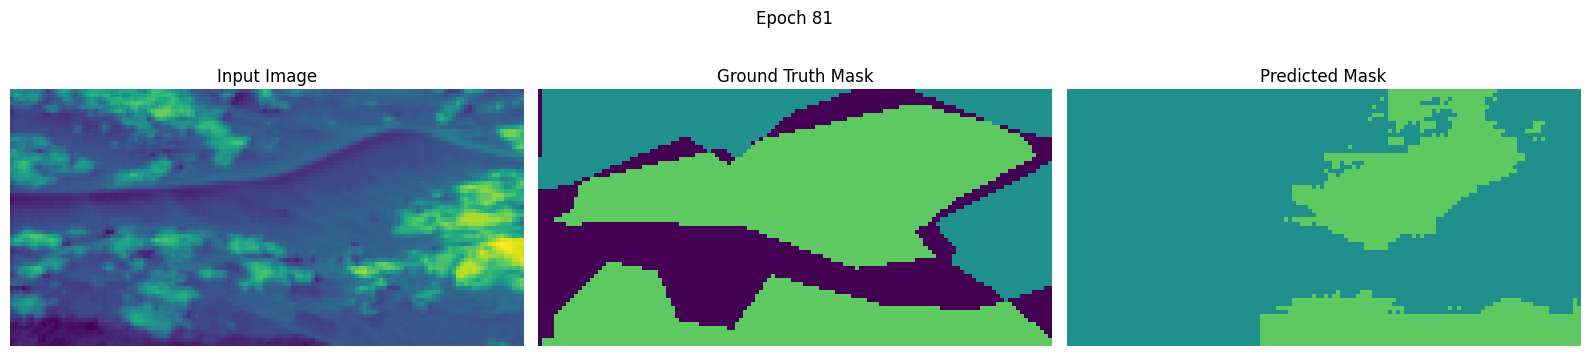

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6999 - loss: 0.0899 - mean_iou: 0.7671 - val_accuracy: 0.6568 - val_loss: 0.2590 - val_mean_iou: 0.5791
Epoch 82/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6940 - loss: 0.0895 - mean_iou: 0.7751 - val_accuracy: 0.6588 - val_loss: 0.2312 - val_mean_iou: 0.5859
Epoch 83/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6978 - loss: 0.0860 - mean_iou: 0.7725 - val_accuracy: 0.6583 - val_loss: 0.2217 - val_mean_iou: 0.5872
Epoch 84/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6993 - loss: 0.0877 - mean_iou: 0.7527 - val_accuracy: 0.6677 - val_loss: 0.2079 - val_mean_iou: 0.5968
Epoch 85/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7013 - loss: 0.0795 - mean_iou: 0.7866 - val_accuracy: 0.6744 - val_loss: 0.2053 - val_mean_iou: 0.6059
Epoch 86/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6972 - loss: 0.0832 - mean_iou: 0.7823

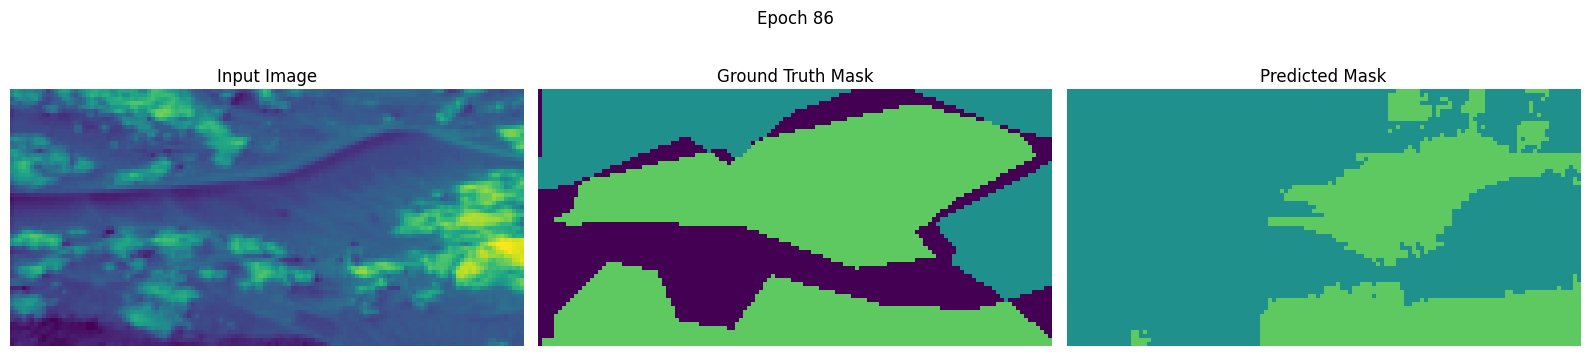

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6972 - loss: 0.0832 - mean_iou: 0.7825 - val_accuracy: 0.6742 - val_loss: 0.2126 - val_mean_iou: 0.6037
Epoch 87/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6979 - loss: 0.0850 - mean_iou: 0.7764 - val_accuracy: 0.5992 - val_loss: 0.3172 - val_mean_iou: 0.5008
Epoch 88/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7025 - loss: 0.0816 - mean_iou: 0.7452 - val_accuracy: 0.6768 - val_loss: 0.1972 - val_mean_iou: 0.6114
Epoch 89/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7029 - loss: 0.0752 - mean_iou: 0.7897 - val_accuracy: 0.6629 - val_loss: 0.2240 - val_mean_iou: 0.5925
Epoch 90/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6963 - loss: 0.0903 - mean_iou: 0.7400 - val_accuracy: 0.6697 - val_loss: 0.1899 - val_mean_iou: 0.6073
Epoch 91/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7066 - loss: 0.0803 - mean_iou: 0.7543

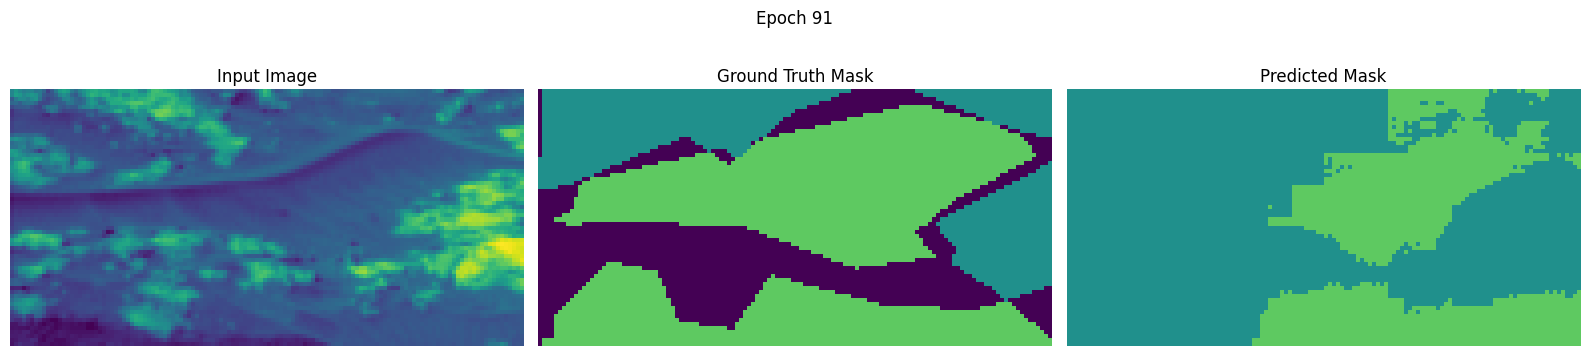

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7063 - loss: 0.0805 - mean_iou: 0.7542 - val_accuracy: 0.6772 - val_loss: 0.2007 - val_mean_iou: 0.6135
Epoch 92/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7004 - loss: 0.0801 - mean_iou: 0.7810 - val_accuracy: 0.6680 - val_loss: 0.2027 - val_mean_iou: 0.6001
Epoch 93/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7048 - loss: 0.0764 - mean_iou: 0.8064 - val_accuracy: 0.6757 - val_loss: 0.1880 - val_mean_iou: 0.6119
Epoch 94/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7072 - loss: 0.0699 - mean_iou: 0.7959 - val_accuracy: 0.6628 - val_loss: 0.2166 - val_mean_iou: 0.5923
Epoch 95/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7087 - loss: 0.0731 - mean_iou: 0.7910 - val_accuracy: 0.6764 - val_loss: 0.1964 - val_mean_iou: 0.6085
Epoch 96/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7135 - loss: 0.0627 - mean_iou: 0.8353

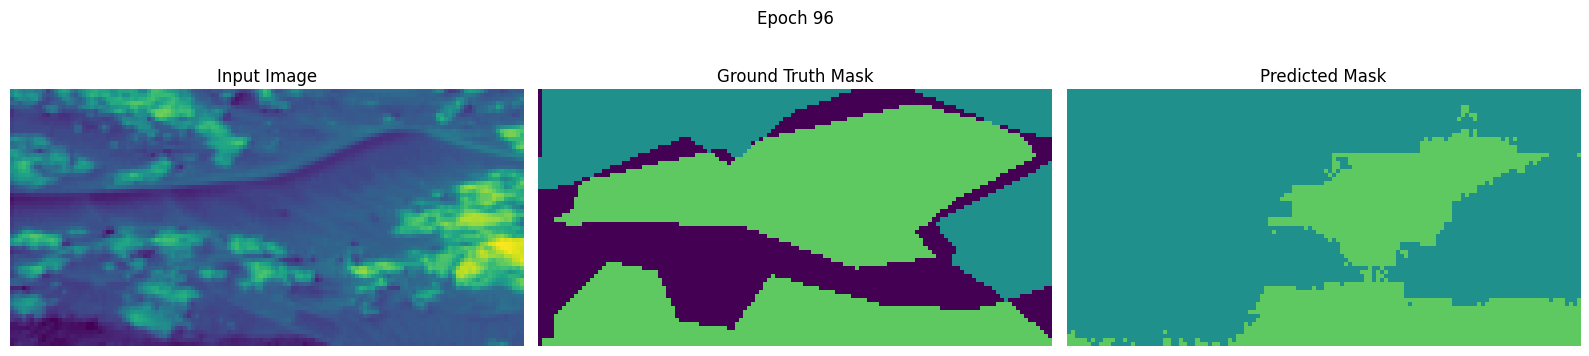

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7134 - loss: 0.0628 - mean_iou: 0.8347 - val_accuracy: 0.6481 - val_loss: 0.2302 - val_mean_iou: 0.5659
Epoch 97/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7030 - loss: 0.0722 - mean_iou: 0.8178 - val_accuracy: 0.6728 - val_loss: 0.2012 - val_mean_iou: 0.6048
Epoch 98/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7054 - loss: 0.0730 - mean_iou: 0.8169 - val_accuracy: 0.6454 - val_loss: 0.2815 - val_mean_iou: 0.5637
Epoch 99/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7042 - loss: 0.0716 - mean_iou: 0.8039 - val_accuracy: 0.5779 - val_loss: 0.3108 - val_mean_iou: 0.4836
Epoch 100/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7111 - loss: 0.0728 - mean_iou: 0.8274 - val_accuracy: 0.6482 - val_loss: 0.2440 - val_mean_iou: 0.5726
Epoch 101/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7100 - loss: 0.0678 - mean_iou: 0.7993

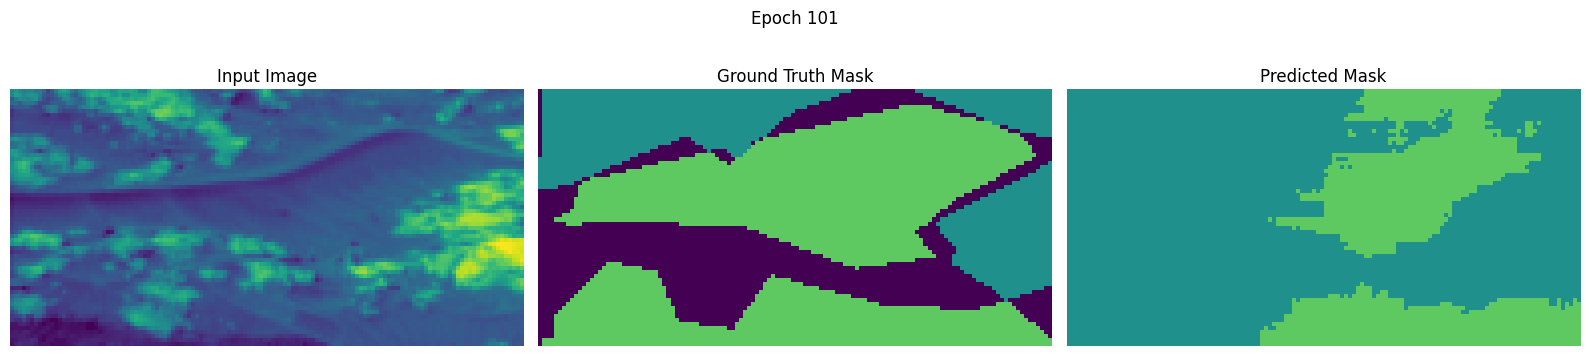

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7100 - loss: 0.0677 - mean_iou: 0.7999 - val_accuracy: 0.6713 - val_loss: 0.2228 - val_mean_iou: 0.6028
Epoch 102/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7142 - loss: 0.0662 - mean_iou: 0.8071 - val_accuracy: 0.6668 - val_loss: 0.2360 - val_mean_iou: 0.5966
Epoch 103/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7111 - loss: 0.0671 - mean_iou: 0.8160 - val_accuracy: 0.6602 - val_loss: 0.2599 - val_mean_iou: 0.5842
Epoch 104/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7097 - loss: 0.0695 - mean_iou: 0.8241 - val_accuracy: 0.6668 - val_loss: 0.2500 - val_mean_iou: 0.5948
Epoch 105/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7130 - loss: 0.0630 - mean_iou: 0.8512 - val_accuracy: 0.6774 - val_loss: 0.2165 - val_mean_iou: 0.6121
Epoch 106/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7152 - loss: 0.0613 - mean_iou: 0.8249

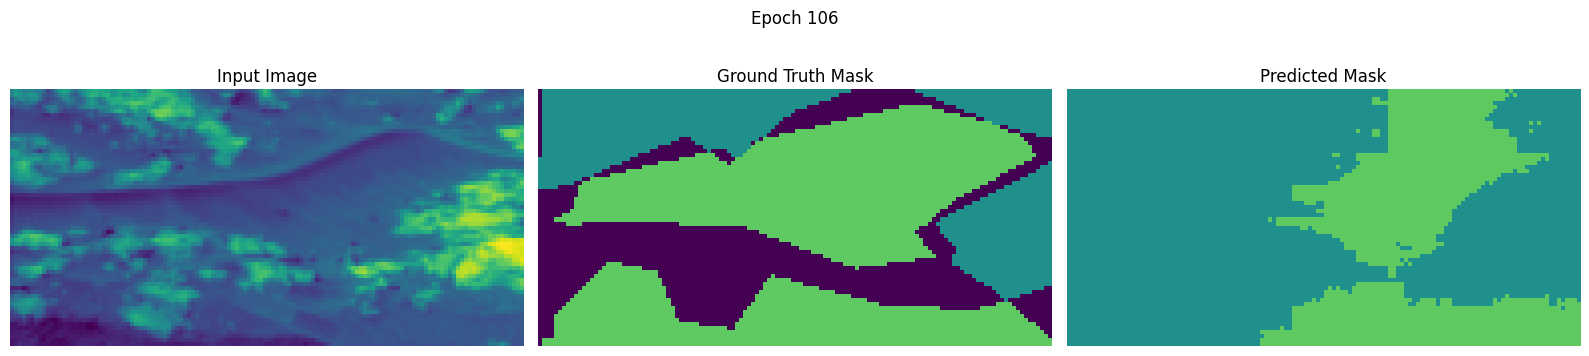

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7151 - loss: 0.0613 - mean_iou: 0.8247 - val_accuracy: 0.6735 - val_loss: 0.2189 - val_mean_iou: 0.6077
Epoch 107/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7171 - loss: 0.0607 - mean_iou: 0.8734 - val_accuracy: 0.6602 - val_loss: 0.2288 - val_mean_iou: 0.5895
Epoch 108/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7188 - loss: 0.0578 - mean_iou: 0.8039 - val_accuracy: 0.6520 - val_loss: 0.2452 - val_mean_iou: 0.5751
Epoch 109/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7194 - loss: 0.0572 - mean_iou: 0.8275 - val_accuracy: 0.6725 - val_loss: 0.2246 - val_mean_iou: 0.6062
Epoch 110/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7131 - loss: 0.0649 - mean_iou: 0.8347 - val_accuracy: 0.6412 - val_loss: 0.3224 - val_mean_iou: 0.5476
Epoch 111/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7171 - loss: 0.0617 - mean_iou: 0.8357

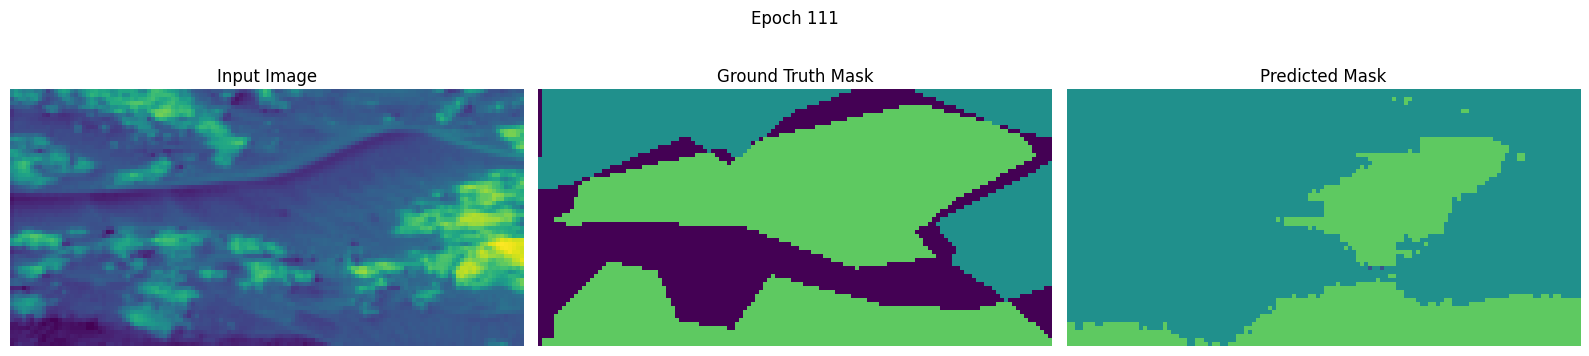

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7170 - loss: 0.0617 - mean_iou: 0.8359 - val_accuracy: 0.6734 - val_loss: 0.2081 - val_mean_iou: 0.6076
Epoch 112/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7230 - loss: 0.0575 - mean_iou: 0.8500 - val_accuracy: 0.6641 - val_loss: 0.1967 - val_mean_iou: 0.5933
Epoch 113/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7165 - loss: 0.0595 - mean_iou: 0.8079 - val_accuracy: 0.6617 - val_loss: 0.2103 - val_mean_iou: 0.5921
Epoch 114/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7204 - loss: 0.0573 - mean_iou: 0.8469 - val_accuracy: 0.6658 - val_loss: 0.2309 - val_mean_iou: 0.5951
Epoch 115/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7218 - loss: 0.0530 - mean_iou: 0.8279 - val_accuracy: 0.6619 - val_loss: 0.2111 - val_mean_iou: 0.5908
Epoch 116/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7245 - loss: 0.0527 - mean_iou: 0.8630

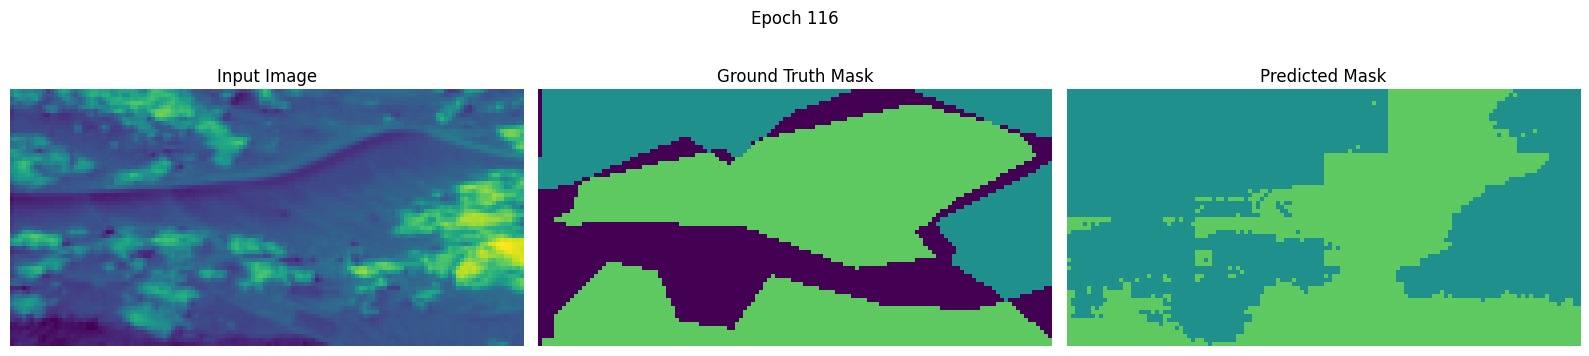

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7243 - loss: 0.0528 - mean_iou: 0.8627 - val_accuracy: 0.6680 - val_loss: 0.2189 - val_mean_iou: 0.6007
Epoch 117/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7176 - loss: 0.0544 - mean_iou: 0.8342 - val_accuracy: 0.6617 - val_loss: 0.2191 - val_mean_iou: 0.5941
Epoch 118/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7218 - loss: 0.0532 - mean_iou: 0.8622 - val_accuracy: 0.6442 - val_loss: 0.2403 - val_mean_iou: 0.5640
Epoch 119/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7271 - loss: 0.0470 - mean_iou: 0.8605 - val_accuracy: 0.6312 - val_loss: 0.3301 - val_mean_iou: 0.5446
Epoch 120/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7268 - loss: 0.0565 - mean_iou: 0.8348 - val_accuracy: 0.6327 - val_loss: 0.2628 - val_mean_iou: 0.5462
Epoch 121/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7148 - loss: 0.0595 - mean_iou: 0.8570

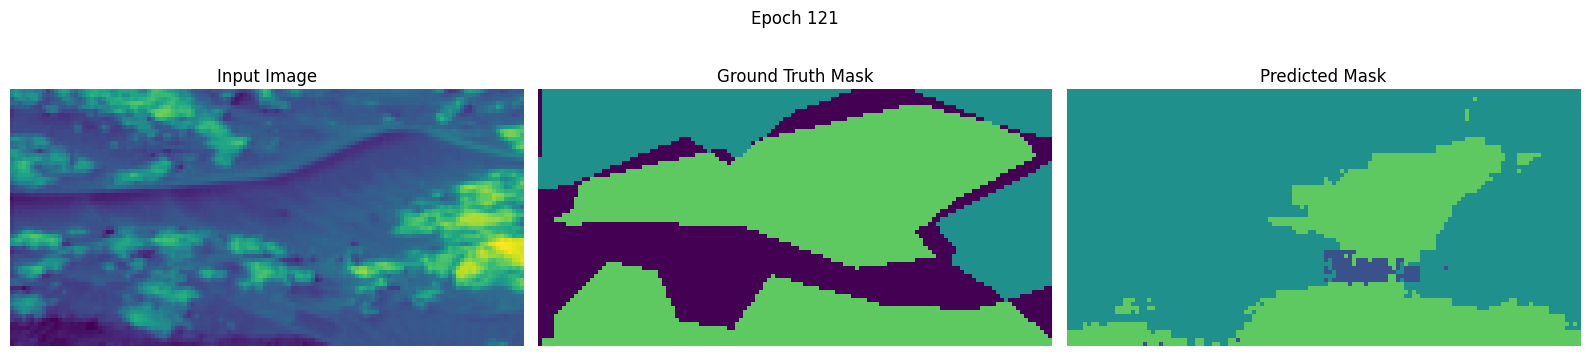

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7148 - loss: 0.0595 - mean_iou: 0.8565 - val_accuracy: 0.6585 - val_loss: 0.2488 - val_mean_iou: 0.5826
Epoch 122/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7189 - loss: 0.0555 - mean_iou: 0.8360 - val_accuracy: 0.6632 - val_loss: 0.2810 - val_mean_iou: 0.5866
Epoch 123/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7247 - loss: 0.0488 - mean_iou: 0.8833 - val_accuracy: 0.6648 - val_loss: 0.2199 - val_mean_iou: 0.5975
Epoch 124/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7210 - loss: 0.0545 - mean_iou: 0.8287 - val_accuracy: 0.6312 - val_loss: 0.2562 - val_mean_iou: 0.5554
Epoch 125/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7164 - loss: 0.0623 - mean_iou: 0.7697 - val_accuracy: 0.6649 - val_loss: 0.2493 - val_mean_iou: 0.5954
Epoch 126/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7208 - loss: 0.0565 - mean_iou: 0.8614

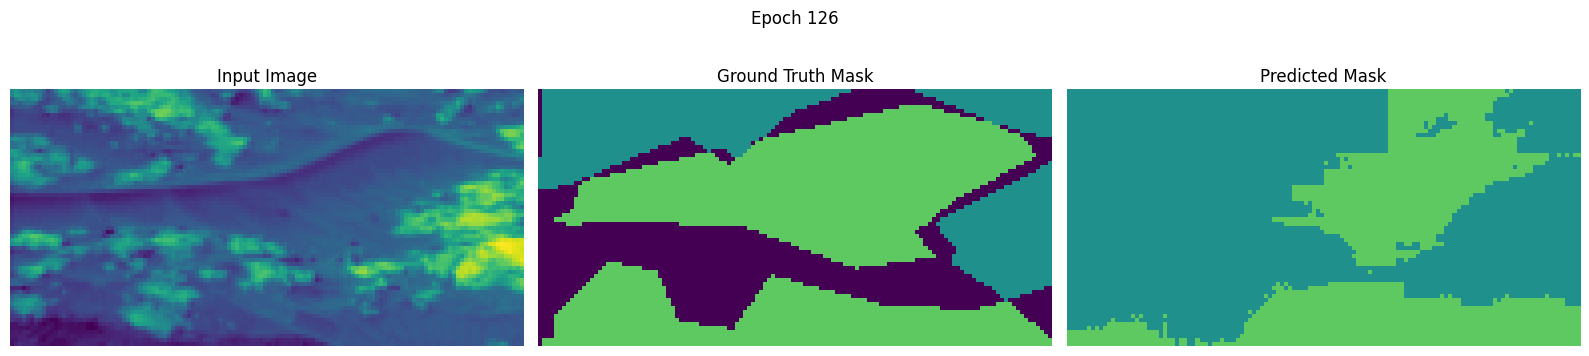

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7208 - loss: 0.0563 - mean_iou: 0.8617 - val_accuracy: 0.6618 - val_loss: 0.2259 - val_mean_iou: 0.5899
Epoch 127/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7240 - loss: 0.0486 - mean_iou: 0.8589 - val_accuracy: 0.6648 - val_loss: 0.2359 - val_mean_iou: 0.5959
Epoch 128/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7219 - loss: 0.0508 - mean_iou: 0.8459 - val_accuracy: 0.6609 - val_loss: 0.2197 - val_mean_iou: 0.5855
Epoch 129/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7284 - loss: 0.0450 - mean_iou: 0.8920 - val_accuracy: 0.6757 - val_loss: 0.2162 - val_mean_iou: 0.6133
Epoch 130/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7260 - loss: 0.0478 - mean_iou: 0.8776 - val_accuracy: 0.6753 - val_loss: 0.2457 - val_mean_iou: 0.6109
Epoch 131/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7270 - loss: 0.0648 - mean_iou: 0.8197

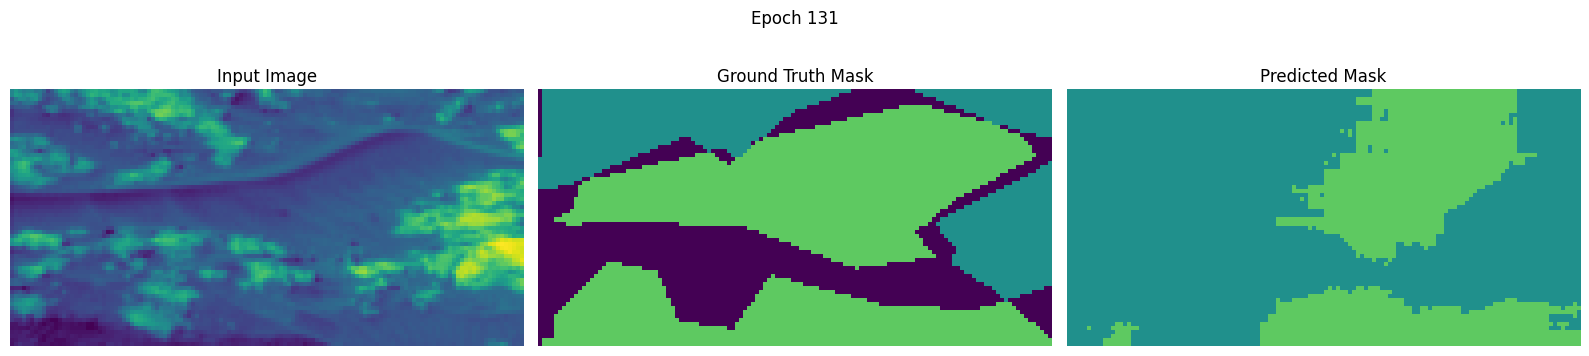

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7268 - loss: 0.0644 - mean_iou: 0.8207 - val_accuracy: 0.6625 - val_loss: 0.2379 - val_mean_iou: 0.5901
Epoch 132/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7257 - loss: 0.0535 - mean_iou: 0.8450 - val_accuracy: 0.6614 - val_loss: 0.2598 - val_mean_iou: 0.5906
Epoch 133/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7267 - loss: 0.0501 - mean_iou: 0.8707 - val_accuracy: 0.6447 - val_loss: 0.2618 - val_mean_iou: 0.5637
Epoch 134/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7140 - loss: 0.0643 - mean_iou: 0.8267 - val_accuracy: 0.6713 - val_loss: 0.2296 - val_mean_iou: 0.6042
Epoch 135/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7293 - loss: 0.0457 - mean_iou: 0.8778 - val_accuracy: 0.6698 - val_loss: 0.2202 - val_mean_iou: 0.5999
Epoch 136/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7243 - loss: 0.0499 - mean_iou: 0.8703

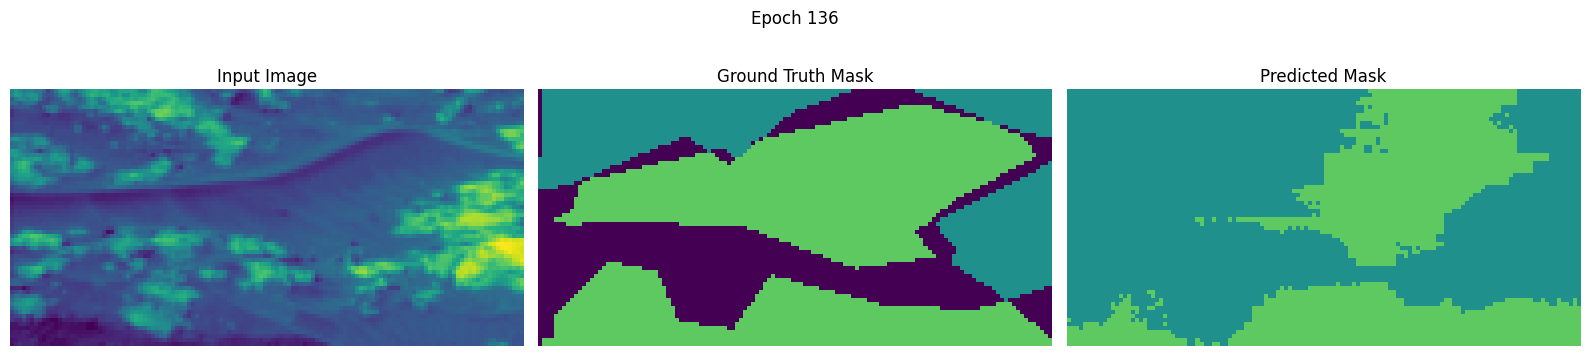

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7242 - loss: 0.0499 - mean_iou: 0.8704 - val_accuracy: 0.6737 - val_loss: 0.2231 - val_mean_iou: 0.6071
Epoch 137/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7254 - loss: 0.0421 - mean_iou: 0.8986 - val_accuracy: 0.6747 - val_loss: 0.2161 - val_mean_iou: 0.6089
Epoch 138/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7263 - loss: 0.0461 - mean_iou: 0.8835 - val_accuracy: 0.6730 - val_loss: 0.2341 - val_mean_iou: 0.6050
Epoch 139/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7304 - loss: 0.0422 - mean_iou: 0.8649 - val_accuracy: 0.6718 - val_loss: 0.2553 - val_mean_iou: 0.6047
Epoch 140/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7258 - loss: 0.0445 - mean_iou: 0.8615 - val_accuracy: 0.6709 - val_loss: 0.2492 - val_mean_iou: 0.6023
Epoch 141/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7281 - loss: 0.0428 - mean_iou: 0.8982

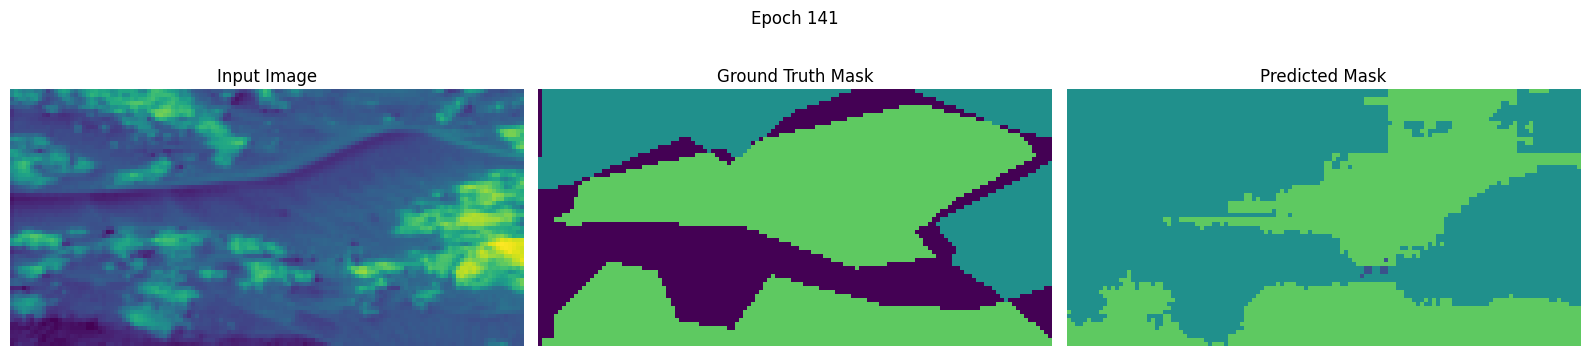

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7280 - loss: 0.0428 - mean_iou: 0.8982 - val_accuracy: 0.6719 - val_loss: 0.2158 - val_mean_iou: 0.6051


In [32]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, vizcallback],
    verbose=1
).history

In [33]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 61.35%


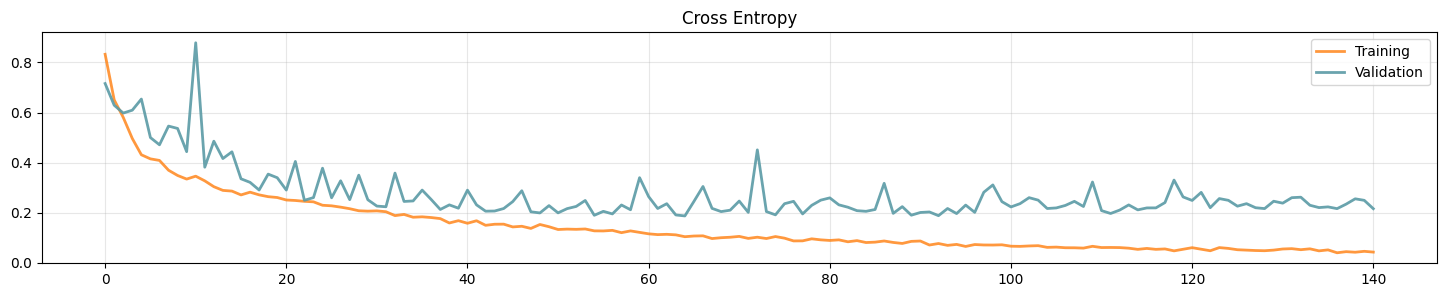

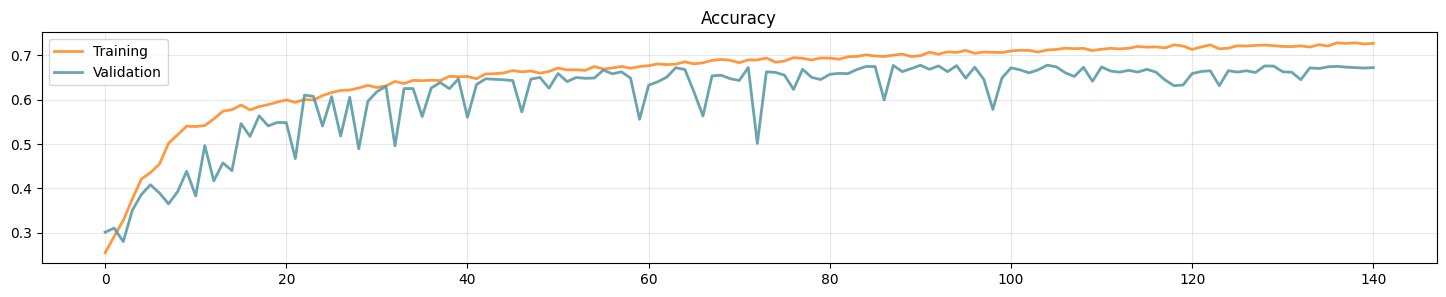

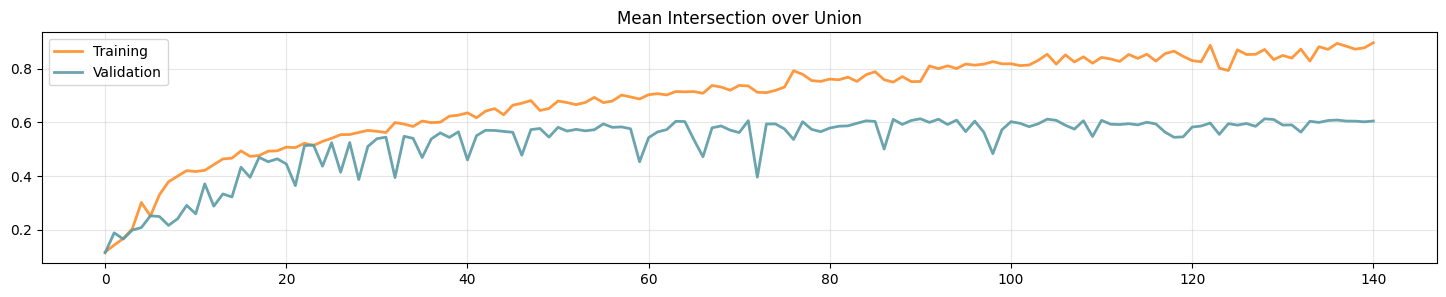

In [34]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [35]:
# Save model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241203_151340.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [36]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [37]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from model_241203_151340.keras


In [38]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

W0000 00:00:1733238827.794831      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733238829.870114      75 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Test Accuracy: 0.6792
Test Mean Intersection over Union: 0.601


In [39]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Predictions shape: (10022, 64, 128)


In [40]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [41]:
# Create and download the csv submission file
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

if IN_COLAB:
    from google.colab import files
    files.download(submission_filename)